# Graded Challenge 4

`DESTI RATNA KOMALA  (RMT-020)`

**Conceptual Problems**

1. Apakah yang dimaksud dengan inertia pada algoritma K-Means ?

  Jawaban:
  - Fungsi inersia digunakan untuk mengukur sejauh mana data  dalam cluster berada dekat dengna pusat cluster.
  - Karena algoritma K-Means menghitung jarak dari seriap data ke setiap centroid, lalu mengassign ke centroid dengan jarak tertentu, maka jaraknya harus dirata-ratakan. Dan total jarak antara dalam 1 cluster tersebut disebut dengan Inersia.
  - semakin kecil nilai inersianya semakin baik nilai K-Meansnya
  - tujuan dari K-Means adalah meminimalkan nilai inersia pada cluster.

2. Jelaskan yang dimaksud dengan Elbow Method (alasan penggunaan, cara penggunaan, kelemahan/kelebihan, dll) !

Jawaban:
  - Metode elbow adalah metode yang digunakan untuk menentukan jumlah cluster yang akan digunakan pada K-Means.
  - Tujuan dari clustering adalah meminimumkan jarak antara data point dengan centroid, dan memaksimumkan jarak antar centroid yang dihitung dengan WCSS (within-cluster sum of squares)
  - Elbow ini bertujuan untuk menghitung WCSS seminimum mungkin dengan jumlah cluster yang kecil agar dapat dilakukan interpretasi data.
    - WCSS: 0 berarti semua data poin berada pada cluster yang berbeda
    - WCSS: 1, berarti semua data poin berada dalam satu cluster

  Cara penggunaaan elbow method, yaitu:
  1. Menghitung inertia/wssc dari setiap cluster
  2. Menghitung sum inertia/wssc untuk semua cluster
  3. Perhitungan pada poin 1 dan poin 2 dilakukan sejumlah n_clusteruntuk mendapatkan nilai wssc dari setiap n_cluster
  4. Melakukan plot wssc dan n_cluster
  5. memilih n)cluster yang variansi inersiannya tidak jauh berbeda dengan n_cluster. Selanjutnya observasi secara visual garis sikunya untuk menentukan berapa jumlah cluster yang ingin dipilih



  - Kelebihan:
    - perhitungan yang sangat simple dan pasti karena hanya perlu melihat garis siku pada garis elbow dan dapat langsung memilih berapa komponen yang akan digunakan
  - Secara komputasi lebih cepat, karena tidak mempertimbangkan jarak antar cluster seperti silhouette
  - Kekurangannya:
    - metode elbow tidak memperdulikan dimensi dari cluster data. Sehingga meskipun skor elbow tinggi, bukan berarti jumlah komponen yang dipilih akan menghasilkan performansi yang baik
    - Dipengaruhi oleh pemilihan algoritma perhitungan jarak. Antara euclidean dan manhattan bisa mempunyai hasil yang berbeda. Oleh karena itu pemilihan algoritma perhitungan jarak perlu dilakukan dengan hati-hati



## 1 Perkenalan

### Judul


**"Pemodelan Clustering untuk melakukan Customer Segmentation dari data kartu kredit selama 6 bulan terakhir"**





### Objective




Perusahaan jasa kartu kredit ingin meningkatkan pendapatan yang lebih signifikan kedepannya. Namun dibutuhkan strategi yang sesuai dengan perilaku dan faktor-faktor pendukung lain dari client. Oleh karena itu dibutuhkan pemodelan clustering untuk membagi client menjadi kelompok-kelompok dengan kemiriman perilaku yang sama, agar strategi bisnis dapat direalisasikan secara optimal dan lebih terarah. Pemodelan clustering dengan menggunakan K-Means dengan metrics elbow dan silhoutte method akan dilakukan pada analisis ini.

## 2 Query SQL


### Data Loading dari Google Cloud Bigquery

Data `credit-card-information` berasal dari project `ftds-hacktiv8-project`, database `phase1_ftds_020_rmt`. Data tersebut di load dan di ambil hanya bilangan genap berdasarkan customer id-nya atau `CUST_ID = genap`. Berikut adalah syntax dari Google Cloud Bigquery.

>```
SELECT *
FROM `ftds-hacktiv8-project.phase1_ftds_020_rmt.credit-card-information`
WHERE mod(CUST_ID,2) = 0;
```

## 3 Import Libraries

Berikut adalah keseluruhan libraries yang digunakan pada analisis dataset ini.

In [1]:
#pengolahan data
import pandas as pd
import numpy as np

#visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

#Feature scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

#handling outliers
from scipy.stats.mstats import winsorize
from scipy.stats import mstats

#evaluasi
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

#Library KMeans
from sklearn.cluster import KMeans

#feature extraction
from sklearn.preprocessing import MinMaxScaler
#dimensionality
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#save data
import joblib
import pickle
import json

## 4 Data Loading

Selanjutnya, upload data raw csv ke akun github dan panggil path data raw tersebut pada `https://raw.githubusercontent.com/destiratnakomala/Hacktiv8_Folder/main/h8dsft_P1G4_desti_ratna_komala.csv`

Variabel baru `df2` dibuat untuk meng-import dataset bertipe `.csv` tersebut

In [2]:
#Untuk membaca file csv yang telah diimport dari big query, gunakan pd.read_csv dengan pd adalah pandas dan .read_csv untuk memanggil file csv
#Variable yang diberikan pada data tersebut adalah df2
data = pd.read_csv(r'https://raw.githubusercontent.com/destiratnakomala/Hacktiv8_Folder/main/h8dsft_P1G4_desti_ratna_komala.csv')

In [3]:
#Copy variable
df=data.copy()



---



### Data Description

Informasi:
- Data kartu kredit sebuah bank selama 6 bulan terakhir

|Kolom|Deskripsi|
|----|----|
|CUST_ID|Nomor identifikasi pemegang kartu kredit|
|BALANCE|Saldo sisa untuk melakukan transaksi|
|BALANCE_FRECUENCY| Seberapa sering saldo diperbaharui, score antara 1: sangat sering, 0: jarang|
|PURCHASES| jumlah pembelian yang dilakukan
|ONEOFF_PURCHASES|maximum jumlah pembelian yang dilakukan lunas/tidak harus dicicil
|INSTALLMENTS_PURCHASES|jumlah pembelian yang dilakukan dengan cicilan/berangsur
|CASH_ADVANCE|uang tunai yang dapat ditarik melalui mesin ATM oleh pengguna kartu kredit
|PURCHASES_FREQUNCY|seberapa sering pembelian dilakukan (1: sering beli, 0: jarang beli
|ONEOFF_PURCHASES_FREQUENCY|Seberapa sering pembelian lunas dilakukan (1: sering, 0:jarang)
|CASH_ADVANCE_FREQUENCY| seberapa sering uang tunai ditarik dari atm(1:sering, 0: jarang)
|CASH_ADVANCE_TRX|jumlah transaksi yang dilakukan dengan tunai CAST IN ADVANCED|
|PURCHASES_TRX|jumlah transaksi pembelian
|CREDIT_LIMIT|Batas penggunakan kartu kredit
|MINIMUM_PAYMENTS|Jumlah minimum pembayaran yang harus dibayar client
|PRC_FULL_PAYMENT|Persentase pembayaran penuh/harga total dari client
|TENURE| Jangka durasi atau waktu yang disepakati untuk melakukan pelunasan pinjaman kartu kredit


Selanjutnya perlu diketahui fitur-fitur pada dataset `credit_card_information`

In [4]:
#tampilkan 10 data awal
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,788,16.581535,0.125000,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,1902,943.584041,0.875000,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8
2,2322,1.979916,0.125000,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
3,3426,461.455720,1.000000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8
4,3976,1053.594730,1.000000,1450.0,1450.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,397.090516,227.143184,0.0,8
5,4266,2237.238086,1.000000,120.0,120.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2500.0,343.102984,712.986387,0.0,8
6,4360,2730.843802,1.000000,2900.0,2900.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2900.0,0.000000,NaN,0.0,8
7,4680,424.994385,0.375000,1200.0,1200.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,57.266292,56.720210,0.0,8
8,5884,18.885677,0.375000,57.0,57.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8
9,24,0.004816,0.545455,51.7,0.0,51.7,0.0,0.250,0.000,0.250,0.0,0,3,3000.0,33.249088,0.059481,0.0,12


In [5]:
#tampilkan 10 data terakhir
df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4465,1588,538.768762,0.909091,226.95,129.58,97.37,452.009130,0.545455,0.090909,0.454545,0.272727,8,9,1200.0,946.649324,211.220001,0.000000,11
4466,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.000000,11
4467,2528,427.642111,0.888889,0.00,0.00,0.00,2563.705644,0.000000,0.000000,0.000000,0.888889,62,0,1200.0,2853.967334,146.976542,0.500000,9
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.000000,9
4469,2152,1420.727073,1.000000,0.00,0.00,0.00,311.804499,0.000000,0.000000,0.000000,0.900000,9,0,1500.0,506.765033,449.179818,0.000000,10
4470,4630,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.545455,9,0,1200.0,1379.635287,271.364415,0.090909,11
4471,8614,809.582978,0.909091,0.00,0.00,0.00,3819.672466,0.000000,0.000000,0.000000,0.545455,7,0,4150.0,4372.148648,241.645387,0.090909,11
4472,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11
4473,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11
4474,3564,1977.007090,1.000000,1032.04,226.90,805.14,4335.919227,0.909091,0.090909,0.818182,0.545455,21,17,4000.0,3056.424974,910.707525,0.090909,11


In [6]:
#cek ukuran data
df.shape

(4475, 18)

In [7]:
#Tampilkan data unik pada tiap kolom
df.nunique()

CUST_ID                             4475
BALANCE                             4439
BALANCE_FREQUENCY                     42
PURCHASES                           3218
ONEOFF_PURCHASES                    2073
INSTALLMENTS_PURCHASES              2357
CASH_ADVANCE                        2155
PURCHASES_FREQUENCY                   47
ONEOFF_PURCHASES_FREQUENCY            44
PURCHASES_INSTALLMENTS_FREQUENCY      47
CASH_ADVANCE_FREQUENCY                46
CASH_ADVANCE_TRX                      55
PURCHASES_TRX                        147
CREDIT_LIMIT                         153
PAYMENTS                            4350
MINIMUM_PAYMENTS                    4317
PRC_FULL_PAYMENT                      47
TENURE                                 7
dtype: int64

In [8]:
# menampilkan fitur pada df
df.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

In [9]:
#Tampilkan informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [10]:
#cek apakah terdapat missing value
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [11]:
#mengecek apakah terdapat data terduplikasi?
df.duplicated().sum()

0



---


***Notes Hasil Data Loading:***
- Data ini memiliki 4475 baris dan 18 kolom/feature
- terdapat 17 feature data numerik
- Semua tipe data sudah sesuai dengan tipe datanya
- `MINIMUM_PAYMENTS` memiliki missing value (perlu di median/mean)
- drop kolom kategorikal `CUST_ID`
- Tidak terdapat data terduplikasi


---



## 5 Exploratory Data Analysis (EDA)

Setelah dilakukan data loading, selanjutnya lakukan eksplorasi data.

In [12]:
#drop kolom kategori
df=data.drop('CUST_ID',axis=1)

In [13]:
#copy dataset ke variabel df_eda
df_eda=df.copy()

#### Fitur Numerikal

In [14]:
#Memisahkan kolom numerical dan kategorikal
dfcat = ['CUST_ID']
dfnum = ['BALANCE','PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE','CASH_ADVANCE_TRX','PURCHASES_TRX','CREDIT_LIMIT','PAYMENTS','MINIMUM_PAYMENTS','PRC_FULL_PAYMENT','TENURE']
dfnumscal = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']

#Print kolom num dan cat
print('Num Columns : ', dfnum)
print('Num Columns (default scaling) : ', dfnumscal)

Num Columns :  ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']
Num Columns (default scaling) :  ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']


### Visualisasi

Pada fitur frekuensi threshold visualisasi akan dibuat menjadi <= 0.5: tidak sering dan > 0.5:sering

#### Balance Frequency

In [15]:
#kelompokkan data menjadi sering dan jarang
df_eda['threshold_BALANCE_FREQUENCY'] = np.where(df_eda['BALANCE_FREQUENCY'] <=0.5, 'Jarang', 'Sering')
#Print jumlah client pada masing-masing threshold
df_eda['threshold_BALANCE_FREQUENCY'].value_counts()

Sering    4002
Jarang     473
Name: threshold_BALANCE_FREQUENCY, dtype: int64

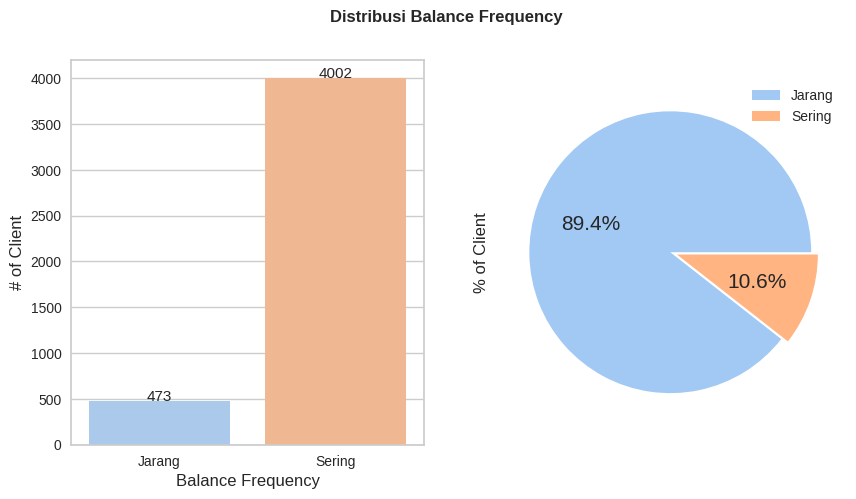

In [16]:
#Visualisasikan data balance frequency
fig, ax =plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='threshold_BALANCE_FREQUENCY', data=df_eda, palette="pastel", ax=ax[0])
ax[0].set_xlabel("Balance Frequency", fontsize= 12)
ax[0].set_ylabel("# of Client", fontsize= 12)
fig.suptitle('Distribusi Balance Frequency', fontsize=12, fontweight='bold')
for p in ax[0].patches:
    ax[0].annotate("%.0f"%(p.get_height()), (p.get_x() + p.get_width() / 2,
                    p.get_height()+48), ha='center', va='center',fontsize = 11)

df_eda['threshold_BALANCE_FREQUENCY'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:5], explode = [0,0.05], textprops = {"fontsize":15})
ax[1].set_ylabel("% of Client", fontsize= 12)
plt.legend(labels=['Jarang', 'Sering'])
plt.show()

Observasi:
- Sangat banyak client yang update balance hingga ~90%
- Hal ini berarti, tingkat transaksi/belanja client juga rata-rata cukup banyak


#### Purchases Frequency

In [17]:
#kelompokkan data menjadi sering dan jarang
df_eda['threshold_PURCHASES_FREQUENCY'] = np.where(df_eda['PURCHASES_FREQUENCY'] <=0.5, 'Jarang', 'Sering')
#Print jumlah client pada masing-masing threshold
df_eda['threshold_PURCHASES_FREQUENCY'].value_counts()

Jarang    2412
Sering    2063
Name: threshold_PURCHASES_FREQUENCY, dtype: int64

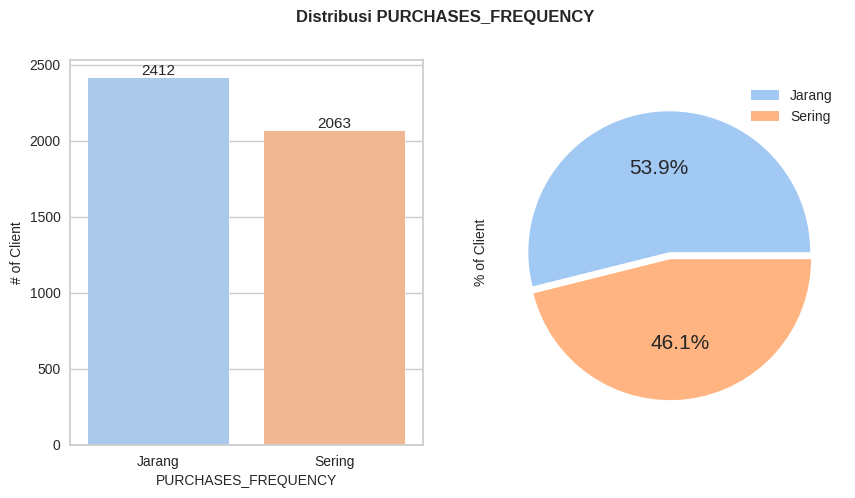

In [18]:
#Visualisasikan data balance frequency
fig, ax =plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='threshold_PURCHASES_FREQUENCY', data=df_eda, palette="pastel", ax=ax[0])
ax[0].set_xlabel("PURCHASES_FREQUENCY", fontsize= 10)
ax[0].set_ylabel("# of Client", fontsize= 10)
fig.suptitle('Distribusi PURCHASES_FREQUENCY', fontsize=12, fontweight='bold')
for p in ax[0].patches:
    ax[0].annotate("%.0f"%(p.get_height()), (p.get_x() + p.get_width() / 2,
                    p.get_height()+48), ha='center', va='center',fontsize = 11)

df_eda['threshold_PURCHASES_FREQUENCY'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:5], explode = [0,0.05], textprops = {"fontsize":15})
ax[1].set_ylabel("% of Client", fontsize= 10)
plt.legend(labels=['Jarang', 'Sering'])
plt.show()

#### OneOFF Purchases Frequency

In [19]:
#kelompokkan data menjadi sering dan jarang
df_eda['threshold_ONEOFF_PURCHASES_FREQUENCY'] = np.where(df_eda['ONEOFF_PURCHASES_FREQUENCY'] <=0.5, 'Jarang', 'Sering')
#Print jumlah client pada masing-masing threshold
df_eda['threshold_ONEOFF_PURCHASES_FREQUENCY'].value_counts()

Jarang    3803
Sering     672
Name: threshold_ONEOFF_PURCHASES_FREQUENCY, dtype: int64

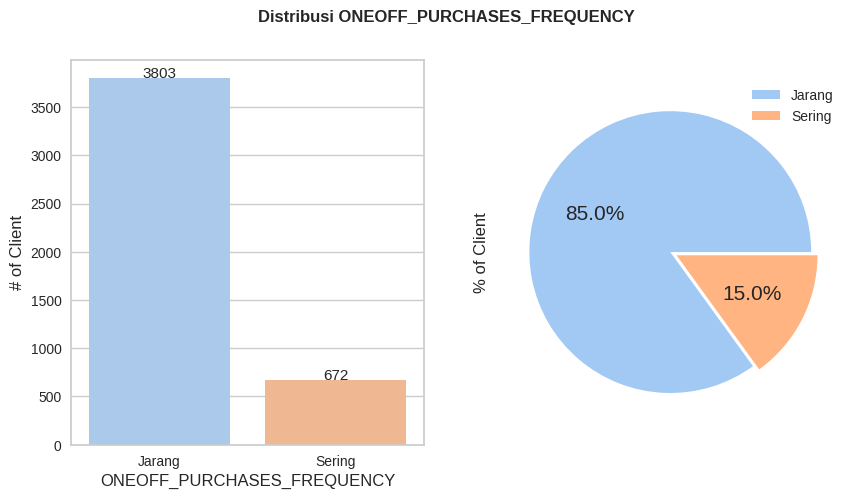

In [20]:
#Visualisasikan data balance frequency
fig, ax =plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='threshold_ONEOFF_PURCHASES_FREQUENCY', data=df_eda, palette="pastel", ax=ax[0])
ax[0].set_xlabel("ONEOFF_PURCHASES_FREQUENCY", fontsize= 12)
ax[0].set_ylabel("# of Client", fontsize= 12)
fig.suptitle('Distribusi ONEOFF_PURCHASES_FREQUENCY', fontsize=12, fontweight='bold')
for p in ax[0].patches:
    ax[0].annotate("%.0f"%(p.get_height()), (p.get_x() + p.get_width() / 2,
                    p.get_height()+48), ha='center', va='center',fontsize = 11)

df_eda['threshold_ONEOFF_PURCHASES_FREQUENCY'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:5], explode = [0,0.05], textprops = {"fontsize":15})
ax[1].set_ylabel("% of Client", fontsize= 12)
plt.legend(labels=['Jarang', 'Sering'])
plt.show()

Observasi:
- Lebih banyak Client yang jarang melakukan pembelian dalam 1x transaksi
- Secara umum, cicilan biasanya lebih mudah dan ringan dibandingkan dengan 1x transaksi

#### Purchases Installments Frequency

In [21]:
#kelompokkan data menjadi sering dan jarang
df_eda['threshold_PURCHASES_INSTALLMENTS_FREQUENCY'] = np.where(df_eda['PURCHASES_INSTALLMENTS_FREQUENCY'] <=0.5, 'Jarang', 'Sering')
#Print jumlah client pada masing-masing threshold
df_eda['threshold_PURCHASES_INSTALLMENTS_FREQUENCY'].value_counts()

Jarang    2931
Sering    1544
Name: threshold_PURCHASES_INSTALLMENTS_FREQUENCY, dtype: int64

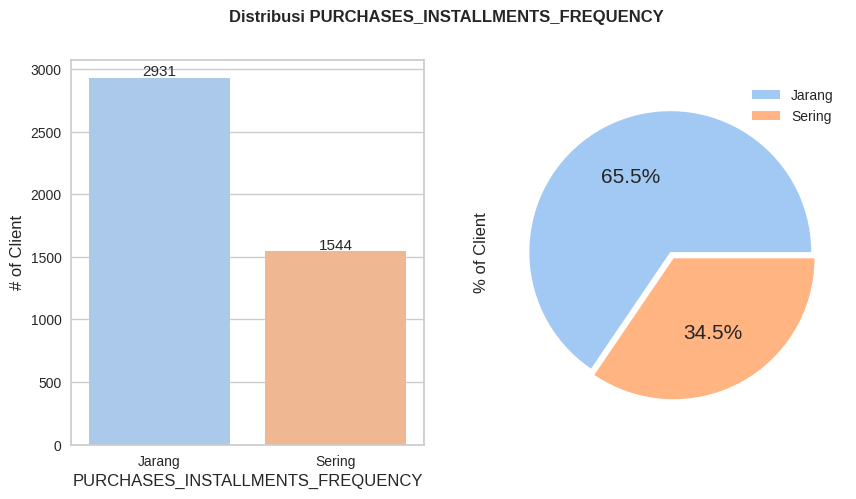

In [22]:
#Visualisasikan data PURCHASES_INSTALLMENTS_FREQUENCY
fig, ax =plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='threshold_PURCHASES_INSTALLMENTS_FREQUENCY', data=df_eda, palette="pastel", ax=ax[0])
ax[0].set_xlabel("PURCHASES_INSTALLMENTS_FREQUENCY", fontsize= 12)
ax[0].set_ylabel("# of Client", fontsize= 12)
fig.suptitle('Distribusi PURCHASES_INSTALLMENTS_FREQUENCY', fontsize=12, fontweight='bold')
for p in ax[0].patches:
    ax[0].annotate("%.0f"%(p.get_height()), (p.get_x() + p.get_width() / 2,
                    p.get_height()+48), ha='center', va='center',fontsize = 11)

df_eda['threshold_PURCHASES_INSTALLMENTS_FREQUENCY'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:5], explode = [0,0.05], textprops = {"fontsize":15})
ax[1].set_ylabel("% of Client", fontsize= 12)
plt.legend(labels=['Jarang', 'Sering'])
plt.show()

Observasi:
- Kebanyakan client jarang melakukan cicilan

#### Cash Advance Frequency

In [23]:
#kelompokkan data menjadi sering dan jarang
df_eda['threshold_CASH_ADVANCE_FREQUENCY'] = np.where(df_eda['CASH_ADVANCE_FREQUENCY'] <=0.5, 'Jarang', 'Sering')
#Print jumlah client pada masing-masing threshold
df_eda['threshold_CASH_ADVANCE_FREQUENCY'].value_counts()

Jarang    4211
Sering     264
Name: threshold_CASH_ADVANCE_FREQUENCY, dtype: int64

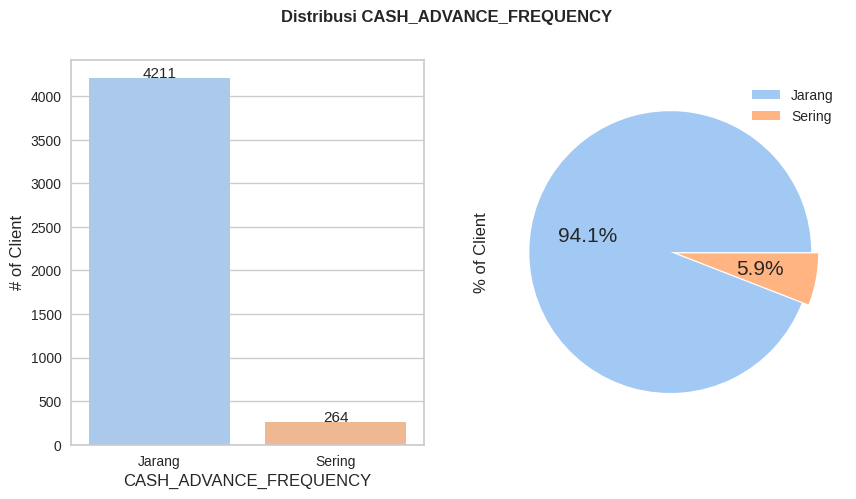

In [24]:
#Visualisasikan data CASH_ADVANCE_FREQUENCY
fig, ax =plt.subplots(1,2,figsize=(10,5))

sns.countplot(x='threshold_CASH_ADVANCE_FREQUENCY', data=df_eda, palette="pastel", ax=ax[0])
ax[0].set_xlabel("CASH_ADVANCE_FREQUENCY", fontsize= 12)
ax[0].set_ylabel("# of Client", fontsize= 12)
fig.suptitle('Distribusi CASH_ADVANCE_FREQUENCY', fontsize=12, fontweight='bold')
for p in ax[0].patches:
    ax[0].annotate("%.0f"%(p.get_height()), (p.get_x() + p.get_width() / 2,
                    p.get_height()+48), ha='center', va='center',fontsize = 11)

df_eda['threshold_CASH_ADVANCE_FREQUENCY'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = sns.color_palette('pastel')[0:5], explode = [0,0.05], textprops = {"fontsize":15})
ax[1].set_ylabel("% of Client", fontsize= 12)
plt.legend(labels=['Jarang', 'Sering'])
plt.show()

Observasi:
- Kebanyakan client jarang melakukan pembelian dengan metode cash advance

#### Balance Amount terhadap Purchase Amounth

In [25]:
df_eda.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'threshold_BALANCE_FREQUENCY',
       'threshold_PURCHASES_FREQUENCY', 'threshold_ONEOFF_PURCHASES_FREQUENCY',
       'threshold_PURCHASES_INSTALLMENTS_FREQUENCY',
       'threshold_CASH_ADVANCE_FREQUENCY'],
      dtype='object')

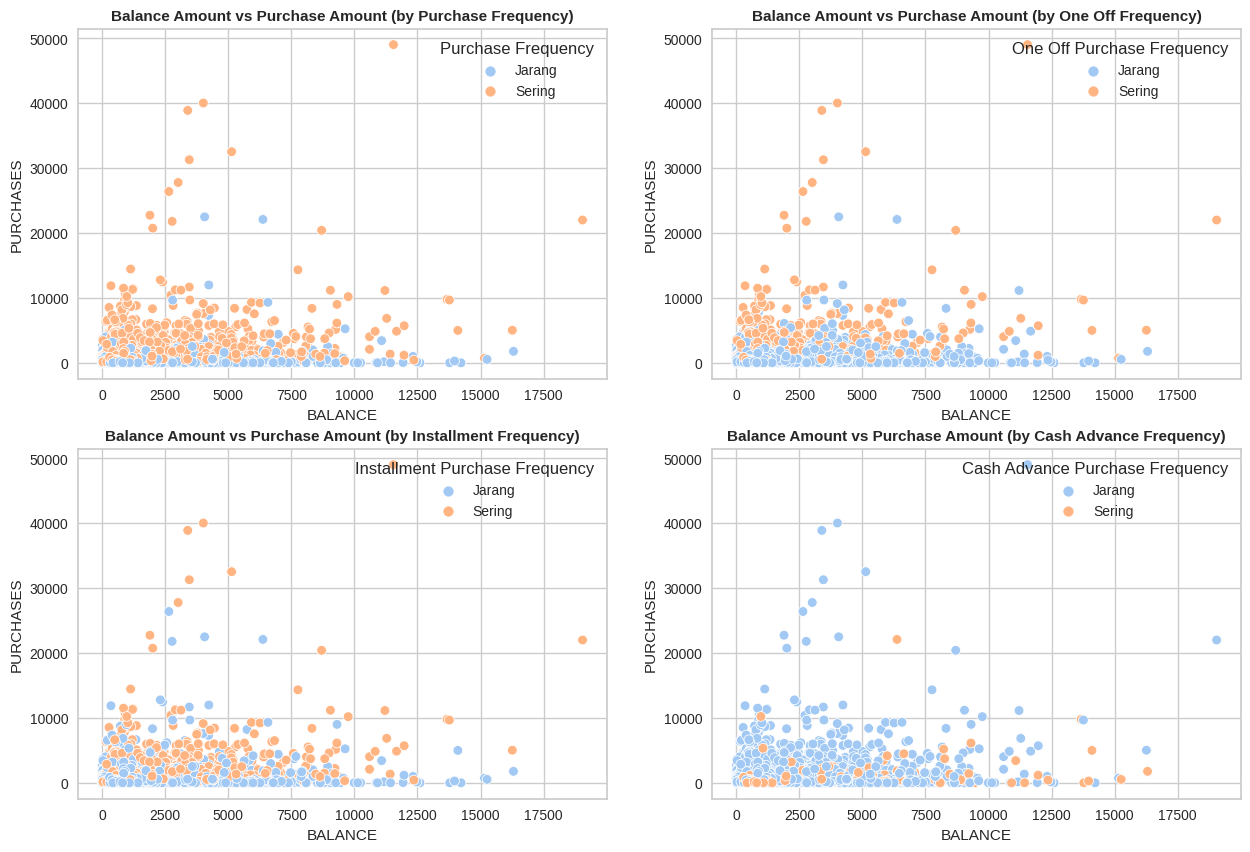

In [26]:
#Visualisasi Balance Amount VS Purchase Amount berdasarkan purchase frequency, oneoff frequency, installments frequency dan cash advance frequency
fig, ax =plt.subplots(2,2,figsize=(15,10))
sns.scatterplot(x="BALANCE", y="PURCHASES", hue="threshold_PURCHASES_FREQUENCY", data=df_eda, ax=ax[0,0], palette= 'pastel')
ax[0,0].set_title('Balance Amount vs Purchase Amount (by Purchase Frequency)', fontsize=11, fontweight='bold')
ax[0,0].legend(title='Purchase Frequency', loc='upper right')

sns.scatterplot(x="BALANCE", y="PURCHASES", hue="threshold_ONEOFF_PURCHASES_FREQUENCY", data=df_eda, ax=ax[0,1], palette= 'pastel')
ax[0,1].set_title('Balance Amount vs Purchase Amount (by One Off Frequency)', fontsize=11, fontweight='bold')
ax[0,1].legend(title='One Off Purchase Frequency', loc='upper right')

sns.scatterplot(x="BALANCE", y="PURCHASES", hue="threshold_PURCHASES_INSTALLMENTS_FREQUENCY", data=df_eda, ax=ax[1,0], palette= 'pastel')
ax[1,0].set_title('Balance Amount vs Purchase Amount (by Installment Frequency)', fontsize=11, fontweight='bold')
ax[1,0].legend(title='Installment Purchase Frequency', loc='upper right')

sns.scatterplot(x="BALANCE", y="PURCHASES", hue="threshold_CASH_ADVANCE_FREQUENCY", data=df_eda, ax=ax[1,1], palette= 'pastel')
ax[1,1].set_title('Balance Amount vs Purchase Amount (by Cash Advance Frequency)', fontsize=11, fontweight='bold')
ax[1,1].legend(title='Cash Advance Purchase Frequency', loc='upper right')
plt.show()

Observasi:
- Client cederung melakukan pembelian dengan harga yang < 30.000
- Client cenderung tidak melakukan pembayaran dengan cash advanced
- Client dengan balance < 7.500 dan purchases > 75.000, lebih sering melakukan oneoff purchases dan installment purchases

## 6 Feature Engineering

Pada feature engineering proses yang akan dilakukan adalah:
1. handle outlier dengan winsorizor
2. check jika ada missing value
3. scaling data
4. kurangi dimensi dengan PCA

### Distribusi Data

In [27]:
#copy data awal setelah drop saja
df_fe=df.copy()

In [28]:
#dapatkan informasi dari data numerik
df_fe[dfnum].describe()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4474.000000,4475.000000,4317.000000,4475.000000,4475.000000
mean,1565.743939,1003.158324,588.504849,415.025075,973.453671,3.196425,14.490503,4494.020175,1726.212274,854.429538,0.157206,11.516425
std,2091.205727,2210.812899,1666.500287,927.360842,2133.464502,6.500169,24.156038,3668.535689,2961.258570,2306.411178,0.295869,1.347819
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.037744,0.000000,6.000000
25%,132.536353,40.065000,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,390.206371,169.814310,0.000000,12.000000
50%,874.905296,362.480000,29.990000,89.450000,0.000000,0.000000,7.000000,3000.000000,831.048408,309.854995,0.000000,12.000000
75%,2058.519163,1122.640000,580.320000,484.255000,1098.569962,4.000000,17.000000,6000.000000,1895.959003,830.395060,0.166667,12.000000
max,19043.138560,49039.570000,40761.250000,22500.000000,29282.109150,110.000000,358.000000,30000.000000,46930.598240,61031.618600,1.000000,12.000000


Observasi:
- Keseluruhan data-data tersebut merupakan distribusi tidak normal skewed ke arah positif (kecuali TENURE)


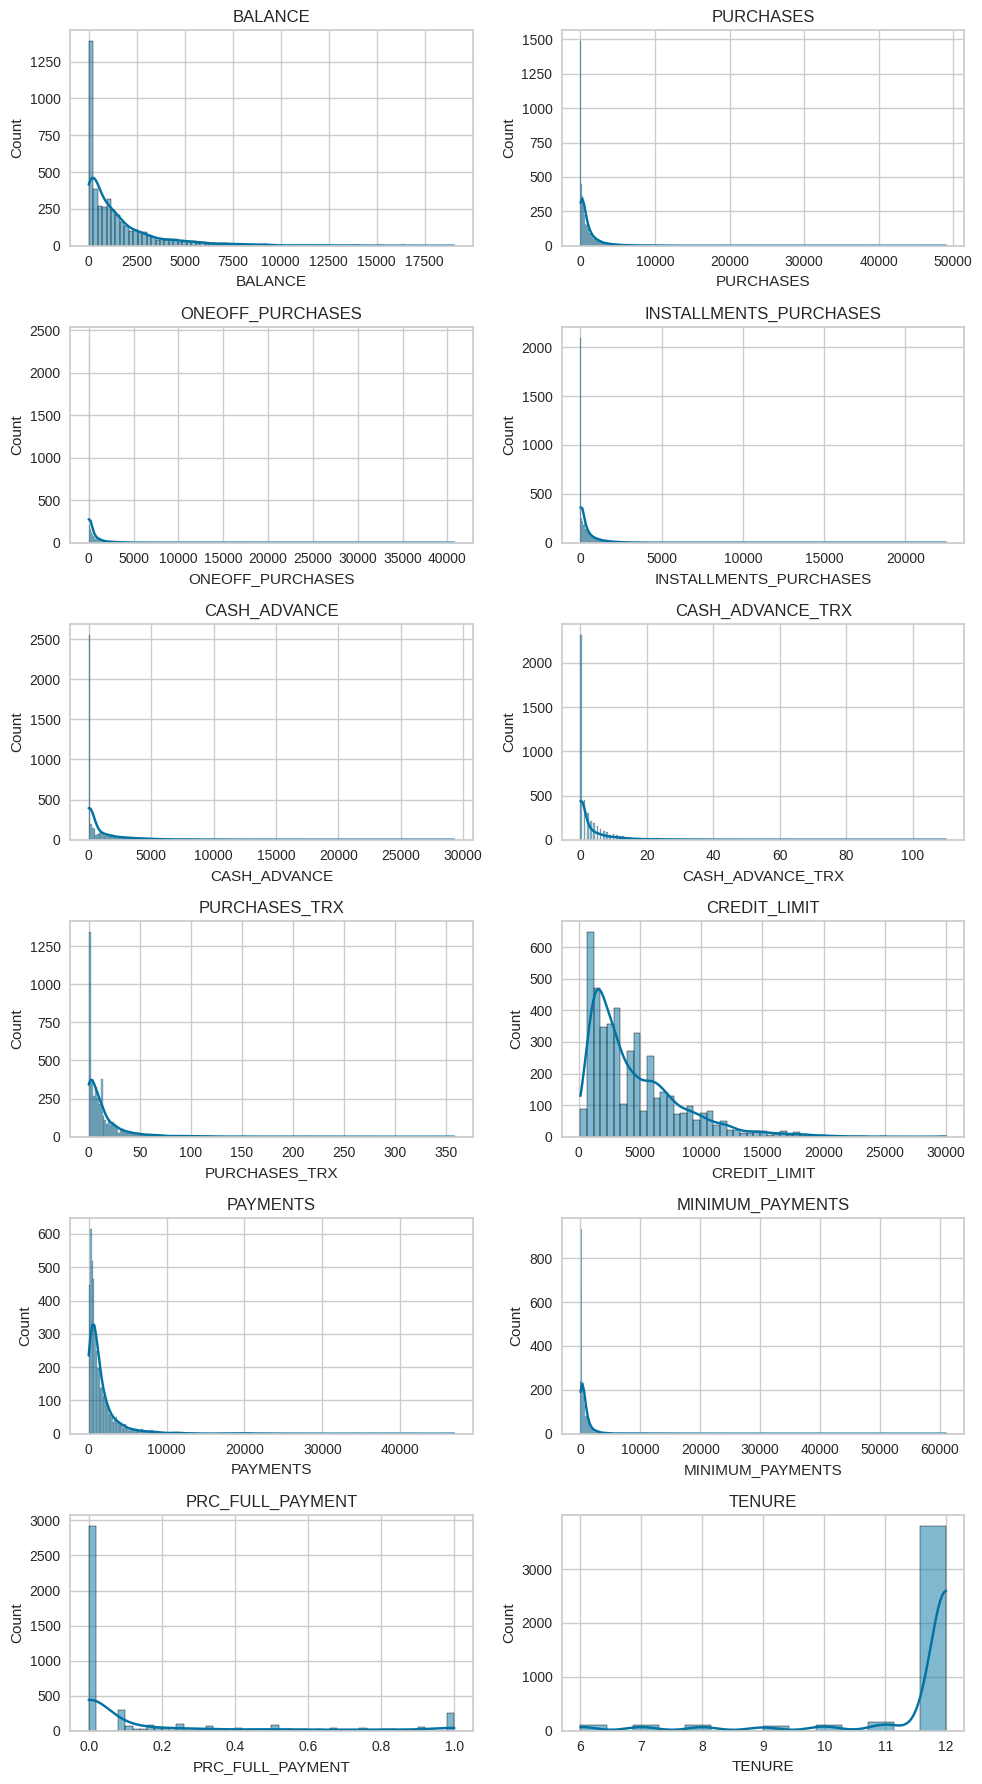

In [29]:
#cek distribusi data
k = len(dfnum)
n = 2
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(df_fe[dfnum].iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    sns.histplot(col,kde=True,ax=ax)
    ax.set_title(name)
fig.tight_layout()

Observasi:
- seluruh data terlihat memiliki distribusi data tidak normal dan skewed ke arah kanan/positif.
- Hanya `TENURE` yang merupakan distribusi tidak normal ber-skewed ke arah kiri/negatif

### Handle Outlier

Menggunakan IQR untuk mengecek/handling outliers:
* kalkulasi kuartil (1 dan 3) Q1 dan
Q3
* evaluasi Interquartile range, IQR=Q3-Q1
* Perkirakan batas bawah dengaan, lower bound=Q1*1.5
* Perkirakan batas atas, upper_bound=Q3*1.5
* Titik-titik data yang berada diluar batas bawah dan batas atas adalah `outlier`


In [30]:
# Cek outlier pada tipe data numerik
numeric_columns = df_fe.select_dtypes(include=[np.number])

# Menghitung IQR untuk kolom numerik
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas atas dan batas bawah untuk mendeteksi outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mendeteksi outliers pada kolom numerik
outliers = (numeric_columns < lower_bound) | (numeric_columns > upper_bound)

# Menghitung jumlah outliers dalam setiap kolom numerik
outliers_count = outliers.sum()
print('sebelum dihandle outlier:\n', outliers_count)

sebelum dihandle outlier:
 BALANCE                             338
BALANCE_FREQUENCY                   745
PURCHASES                           384
ONEOFF_PURCHASES                    487
INSTALLMENTS_PURCHASES              411
CASH_ADVANCE                        516
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          379
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY              372
CASH_ADVANCE_TRX                    402
PURCHASES_TRX                       366
CREDIT_LIMIT                        162
PAYMENTS                            395
MINIMUM_PAYMENTS                    399
PRC_FULL_PAYMENT                    685
TENURE                              668
dtype: int64


#### Visualisasi Oulier

In [31]:
#membuat def untuk boxplot dan grafik distribusi setaip kolom

def distributionplot(df_fe, variable):
    #ukuran ukuran data
    plt.figure(figsize=(16, 3))

    #buat histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram '+ variable )

    #buat boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot ' + variable)

    plt.show()

    #Cek skew feature
    print('\nSkewness Value ',variable, ' : ' , df_fe[variable].skew())

In [32]:
#buat list columns
list_columns = df.columns.to_list()
list_columns

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

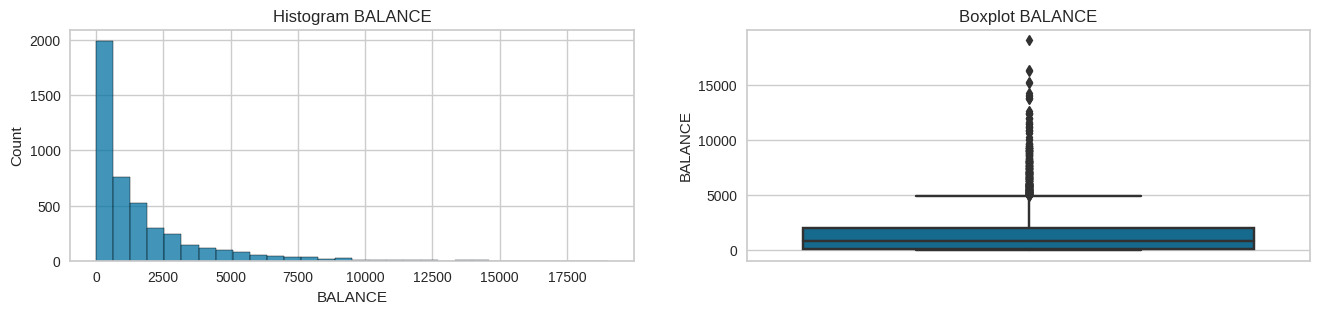


Skewness Value  BALANCE  :  2.456620962191608


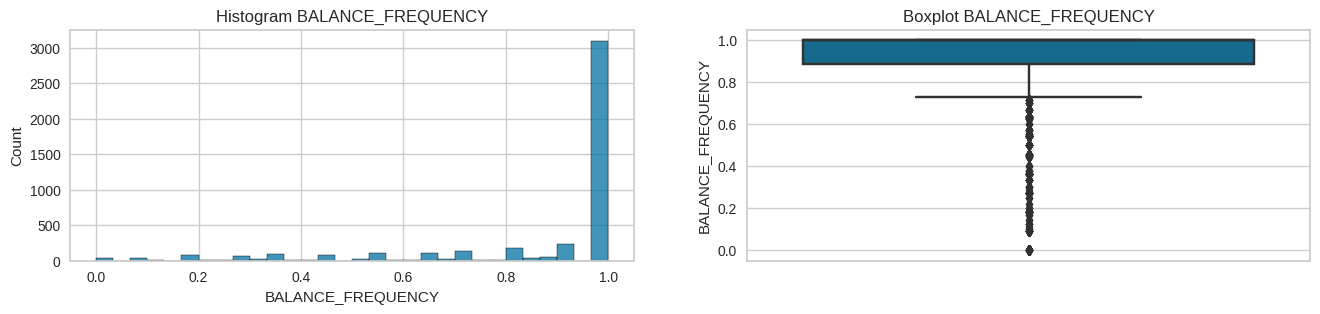


Skewness Value  BALANCE_FREQUENCY  :  -2.020309250153954


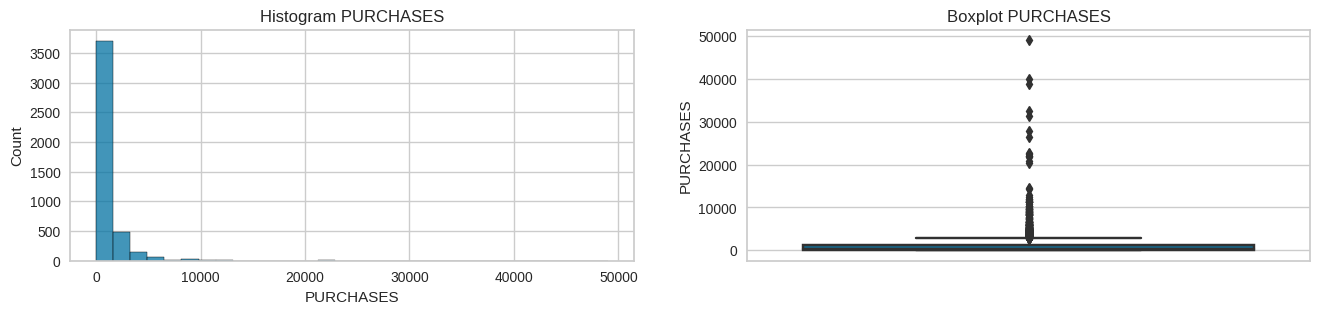


Skewness Value  PURCHASES  :  8.987051591977552


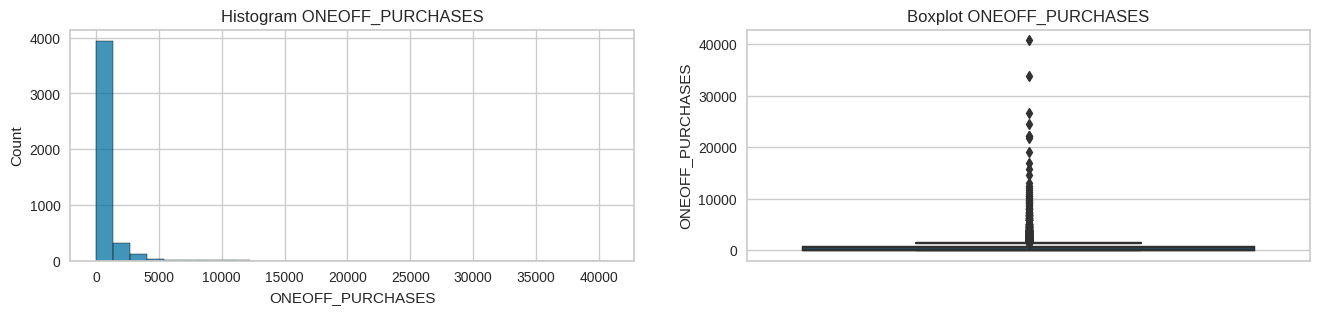


Skewness Value  ONEOFF_PURCHASES  :  10.140058770209015


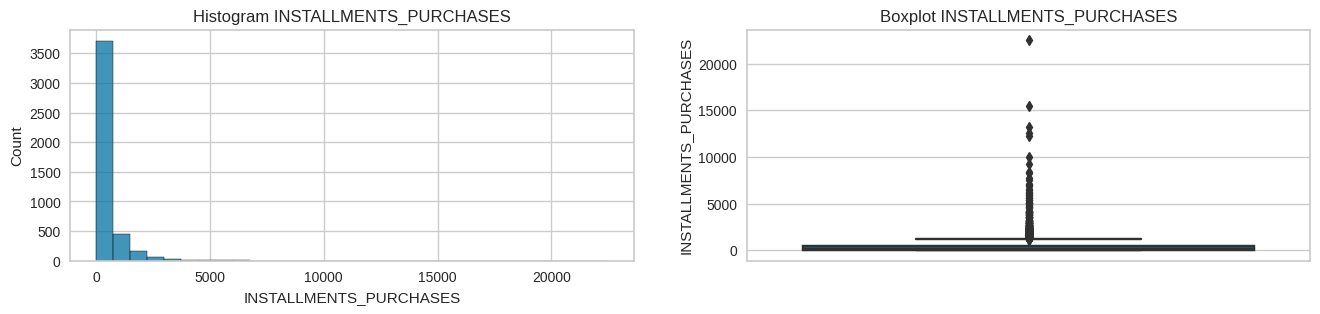


Skewness Value  INSTALLMENTS_PURCHASES  :  8.116887369354234


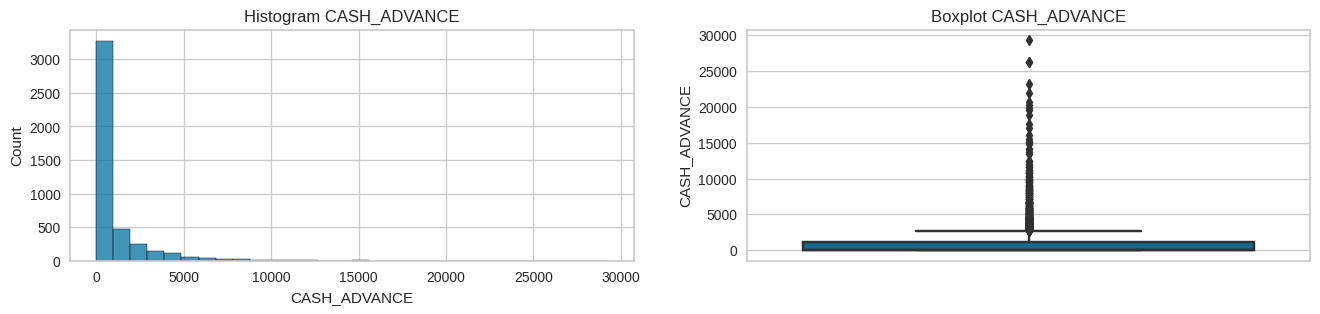


Skewness Value  CASH_ADVANCE  :  4.739677538274201


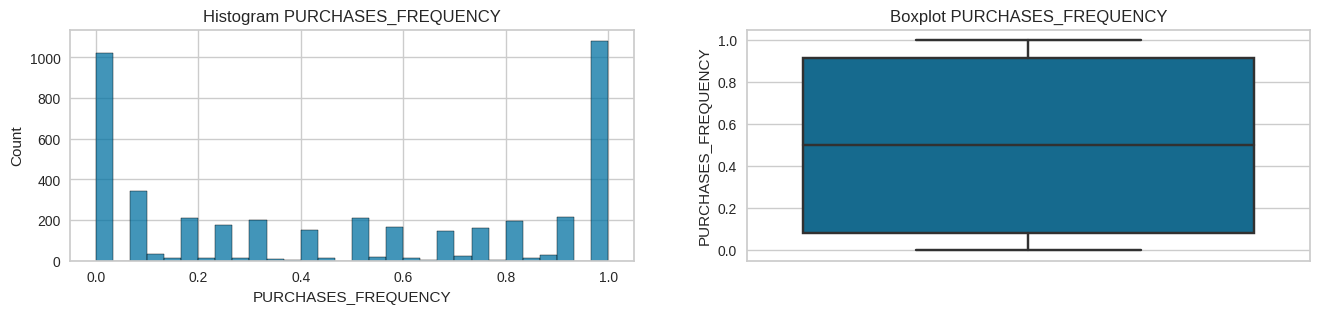


Skewness Value  PURCHASES_FREQUENCY  :  0.06159754482450298


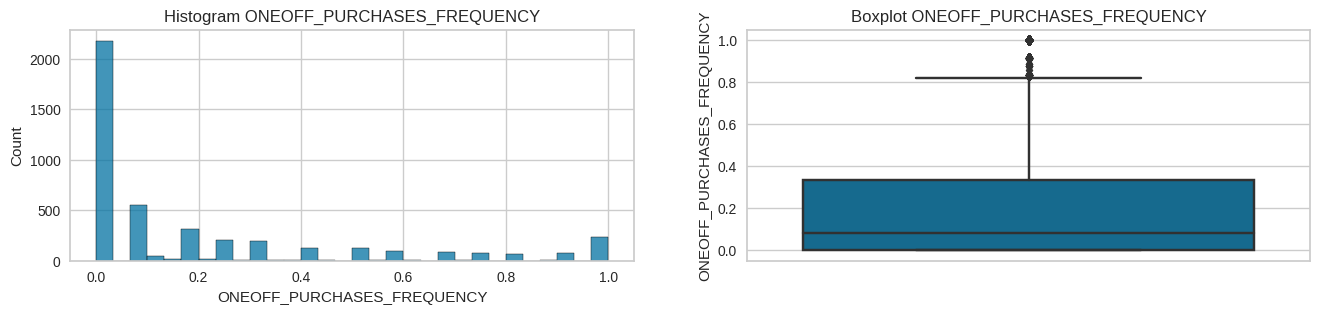


Skewness Value  ONEOFF_PURCHASES_FREQUENCY  :  1.5234554787719887


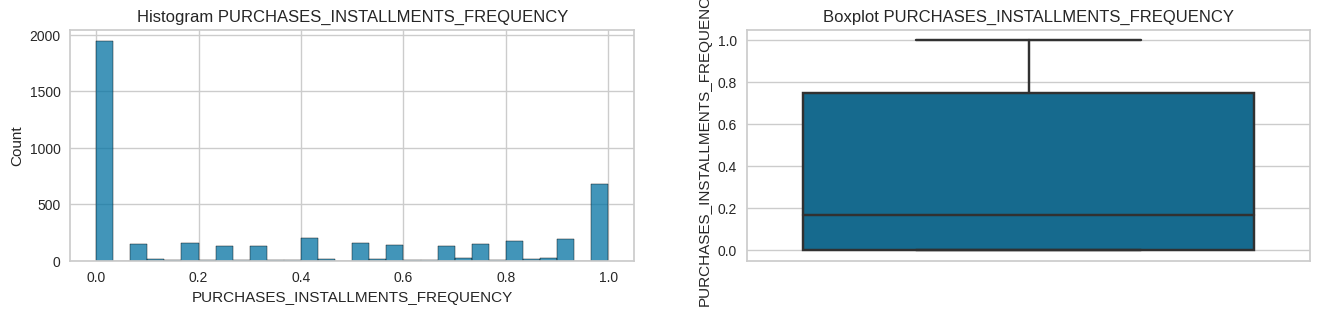


Skewness Value  PURCHASES_INSTALLMENTS_FREQUENCY  :  0.5102876658863782


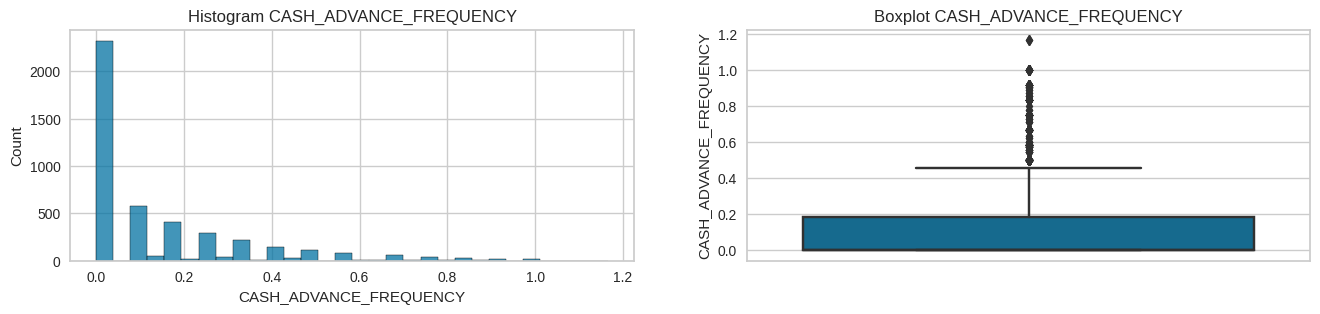


Skewness Value  CASH_ADVANCE_FREQUENCY  :  1.8233800138256115


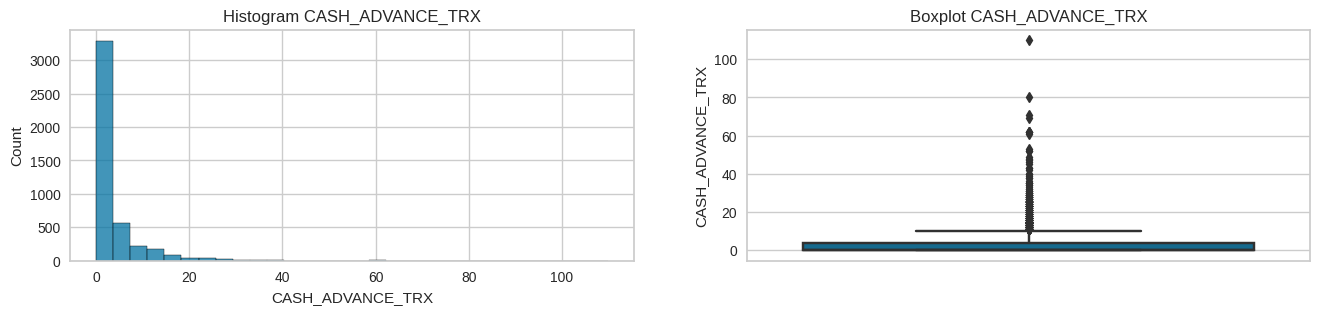


Skewness Value  CASH_ADVANCE_TRX  :  4.75278000331602


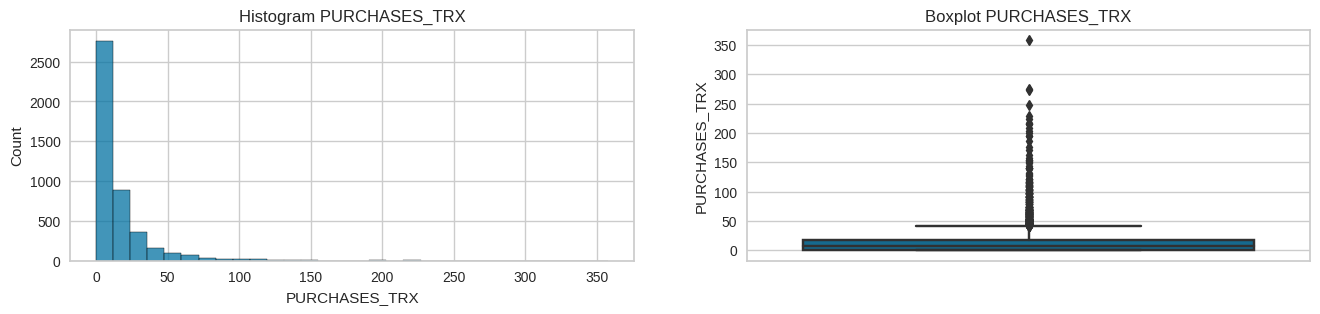


Skewness Value  PURCHASES_TRX  :  4.480452469147952


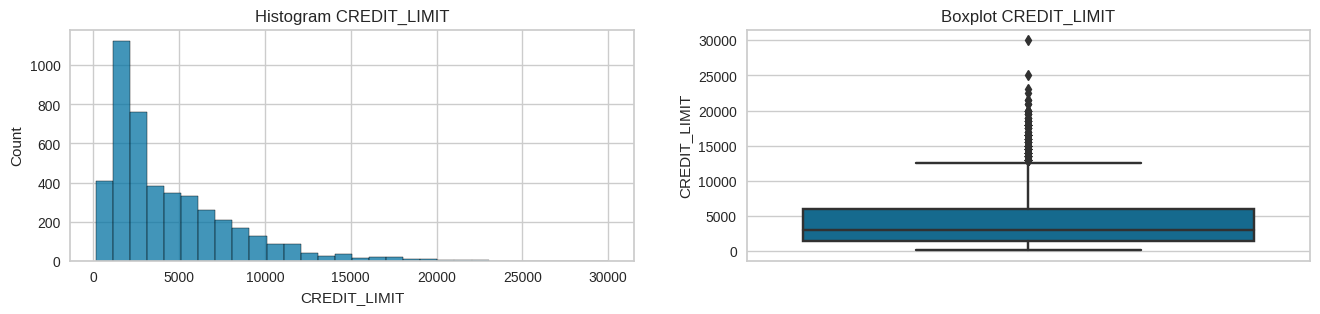


Skewness Value  CREDIT_LIMIT  :  1.5450779677462632


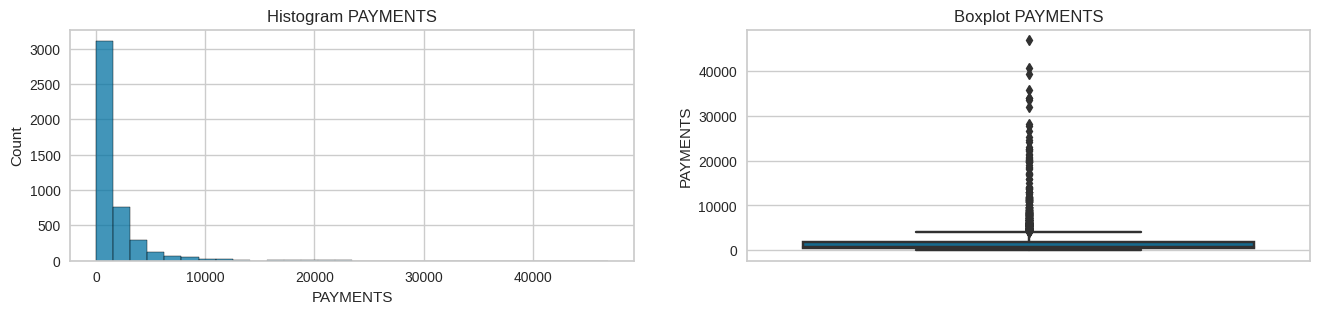


Skewness Value  PAYMENTS  :  6.040773400922328


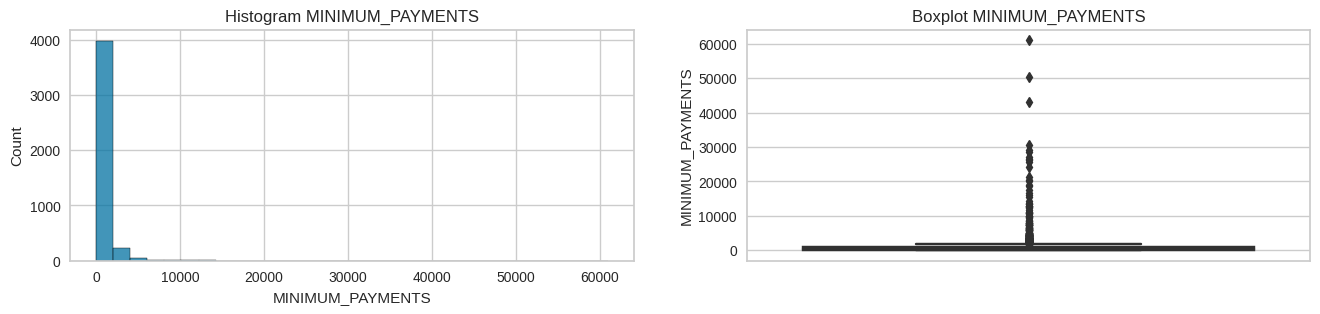


Skewness Value  MINIMUM_PAYMENTS  :  12.357860274482807


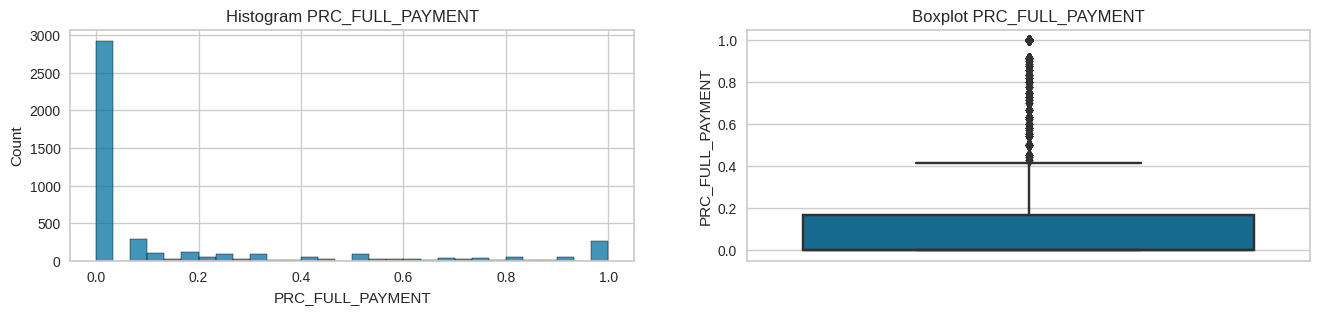


Skewness Value  PRC_FULL_PAYMENT  :  1.9116495684046537


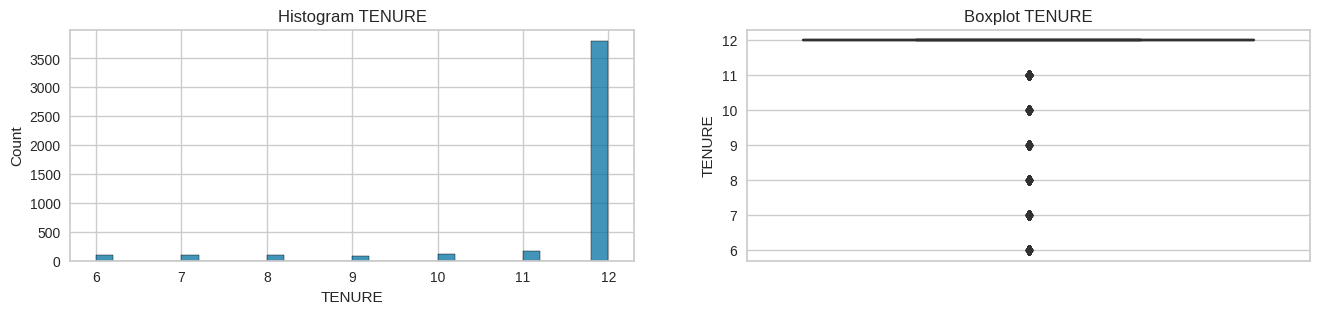


Skewness Value  TENURE  :  -2.9328221430257617


In [33]:
#Menampilkan distribusi data dan menampilkan outlier
for i in list_columns:
    distributionplot(df_fe, i)

Observasi:
- hanya purchase installment dan purchase frekuensi yang tidak memiliki nilai outlier.
- Outlier pada data ini sangat dipengaruhi oleh perilaku pelanggan, sehingga outlier ini masuk akal dan bersifat natural
- Namun, karena pemodelan ini sensitif dengan outlier, maka perlu dilakukan censoring/winsorizer dan tidak dilakukan trimming (karena keseluruhan data sangat penting pengolahan data)

#### Capping Outlier

In [34]:
#ubah outlier ke nan untuk selanjutnya di impute median
# Cek outlier pada tipe data numerik
for column in numeric_columns.columns:
  data = numeric_columns[column]

  # Menghitung IQR untuk kolom numerik
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  # Menentukan batas atas dan batas bawah untuk mendeteksi outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Mendeteksi outliers pada kolom numerik
  outliers = (data < lower_bound) | (data > upper_bound)

  # ubah ke nilai null
  numeric_columns[column].loc[outliers]=np.nan

numeric_columns.isna().sum()

BALANCE                             338
BALANCE_FREQUENCY                   745
PURCHASES                           384
ONEOFF_PURCHASES                    487
INSTALLMENTS_PURCHASES              411
CASH_ADVANCE                        516
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          379
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY              372
CASH_ADVANCE_TRX                    402
PURCHASES_TRX                       366
CREDIT_LIMIT                        163
PAYMENTS                            395
MINIMUM_PAYMENTS                    557
PRC_FULL_PAYMENT                    685
TENURE                              668
dtype: int64

### Missing Value

In [35]:
#check nan
numeric_columns.isna().sum()

BALANCE                             338
BALANCE_FREQUENCY                   745
PURCHASES                           384
ONEOFF_PURCHASES                    487
INSTALLMENTS_PURCHASES              411
CASH_ADVANCE                        516
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY          379
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY              372
CASH_ADVANCE_TRX                    402
PURCHASES_TRX                       366
CREDIT_LIMIT                        163
PAYMENTS                            395
MINIMUM_PAYMENTS                    557
PRC_FULL_PAYMENT                    685
TENURE                              668
dtype: int64

In [36]:
#menggunakan imputer kkn untuk mencari nilai median terdekat dari untuk mengisi nilai nan
from sklearn.impute import KNNImputer
imputer = KNNImputer()
df_imputer = pd.DataFrame(imputer.fit_transform(numeric_columns), columns=numeric_columns.columns)
df_imputer.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Feature Scaling

In [37]:
#copy ke variabel feature scaling baru
df_fs=df_imputer.copy()

In [38]:
#Definisi scaler kemudian fit dan transform. Menggunakan RobustScaler karena distribusi numerik banyak yang skewed
scaler = RobustScaler()
df_fs= pd.DataFrame(scaler.fit_transform(df_fs), columns=df_fs.columns.to_list())
df_fs

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.476294,0.000000,-0.163690,-0.059008,0.323419,0.000000,-0.450000,-0.305555,-0.055556,0.000000,0.000000,-0.316456,-0.400000,-0.570282,0.444951,0.000000,0.0
1,0.042743,-0.125000,-0.262494,0.251340,-0.206385,0.000000,-0.450000,0.152779,-0.222223,0.000000,0.000000,-0.379747,-0.444444,-0.422284,0.130739,0.000000,0.0
2,-0.484470,0.000000,-0.285922,0.182039,-0.206385,0.000000,-0.450000,0.152779,-0.222223,0.000000,0.000000,-0.379747,-0.333333,-0.570282,0.385106,0.000000,0.0
3,-0.227205,0.000000,0.228473,1.703650,-0.206385,0.000000,-0.450000,0.152779,-0.222223,0.000000,0.000000,-0.379747,-0.444444,-0.392930,-0.292217,0.000000,0.0
4,0.104339,0.000000,1.109566,4.309975,-0.206385,0.000000,-0.450000,0.152779,-0.222223,0.000000,0.000000,-0.379747,-0.333333,-0.297352,-0.168909,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,0.118569,0.000000,-0.367411,-0.059008,-0.206385,1.575853,-0.600000,-0.305555,-0.222223,1.618179,3.000000,-0.443038,-0.400000,0.377976,-0.096635,2.727281,0.0
4471,-0.032285,-0.090909,-0.367411,-0.059008,-0.206385,1.885360,-0.600000,-0.305555,-0.222223,1.418179,2.333333,-0.443038,0.255556,1.310996,-0.145207,2.727281,0.0
4472,1.410551,0.000000,0.204006,1.228245,0.147948,2.512405,0.600000,2.361116,0.262625,1.699997,3.000000,0.822785,1.577778,0.143849,0.907988,0.000000,0.0
4473,2.224690,0.000000,1.258211,0.770194,-0.206385,1.086119,-0.054546,1.361112,-0.222223,0.699999,0.133333,1.139241,0.666667,0.052328,1.579016,2.727281,0.0


### Variance Inflation Factor

Sebelum dilakukan PCA, perlu diketahui terlebih dahulu jumlah komponen yang akan direduksi.

In [39]:
df_fs.shape

(4475, 17)

In [40]:
#lakukan fit dan train ke pca
pca = PCA()
pca.fit(df_fs)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.90) + 1

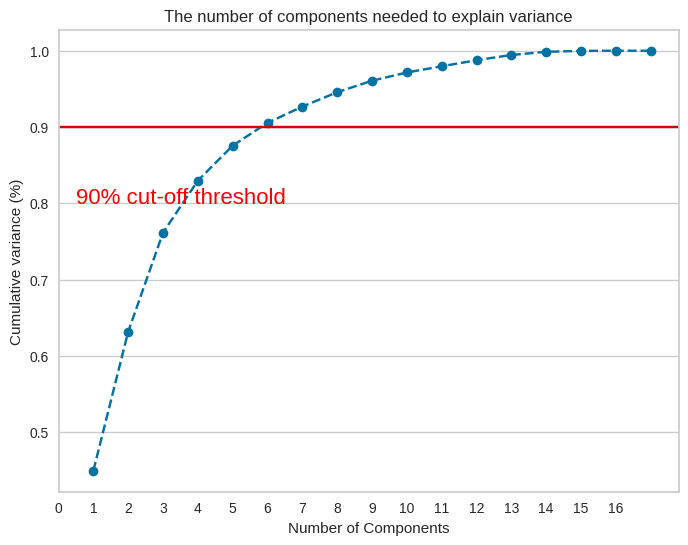

In [41]:
#Plot ke grafik
plt.rcParams["figure.figsize"] = (8,6)

fig, ax = plt.subplots()
xi = np.arange(1, 18, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 17, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.80, '90% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

Berdasarkan grafik tersebut, dapat disimpulkan bahwa `n_component` untuk **PCA yang dapat menjelaskan 90% variansi adalah 6 komponen**. Kenaikan variansi diatas 90%  dan 11 komponen lainnya tidak signifikan.

### PCA

Setelah mengetahui jumlah komponen yang akan direduksi, maka dilakukan PCA

In [42]:
#Reduksi komponen dengan PCA
pca_final = PCA(n_components=6)
pca_final.fit(df_fs)
X_pca = pca_final.transform(df_fs)

#print Shape
print('Shape sebelum reduksi komponen ', df_fs.shape)
print('Jumlah komponen sebelum reduksi ',len(df_fs.columns))
print('---')
print('Shape setelah reduksi komponen ', X_pca.shape)
print('Jumlah komponen setelah reduksi ', pca_final.n_components_)
print('Variansi yang dapat dijelaskan ', round((np.sum(pca_final.explained_variance_ratio_)*100),2), '%')

Shape sebelum reduksi komponen  (4475, 17)
Jumlah komponen sebelum reduksi  17
---
Shape setelah reduksi komponen  (4475, 6)
Jumlah komponen setelah reduksi  6
Variansi yang dapat dijelaskan  90.55 %


Observasi:
- Komponen direduksi dari 17 komponen menjadi 6 komponen
-variansi dari hasil reduksi komponen adalah 90.55%

## 7 Model Definition

>Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

Algoritma yang digunakan pada pemodelan ini adalah **K-Means**.
- Karena K-Means mampu mengolah kumpulan data yang besar tanpa membutuhkan waktu yang lama.
- meskipun sensitif dengan nilai outlier, namun K-Means dapat dengan mudah beradaptasi dengan contoh baru, relatif sederhana dan mudah diterapkan


Karena tujuan clustering adalah mengelompokkan fitur/objek pada data. Maka dibutuhkan metode **elbow** dan **silhouette** untuk menentukan jumlah cluster yang tepat dan membandingkan serta memastikan bahwa performasi dari setiap cluster yang dibuat sudah layak dan baik.  

- elbow dapat membantu memilih n_cluster yang memiliki inersia rendah
- silhouette dapat mengetahui apakah jumlah cluster yang digunakan sudah tepat/belum

**Notes:**
* random_state : 1

## 8 Model Training

Pada model training proses yang akan dilakukan diantarannya:
1. Menentukan jumlah `n_cluster` dengan `elbow` dan dicek kembali dengan 'silhouette'
2. Lakukan clustering
3. visualisasi dengan 2D

### Menentukan Jumlah cluster (Elbow & Silhoutte)

#### Metode Elbow

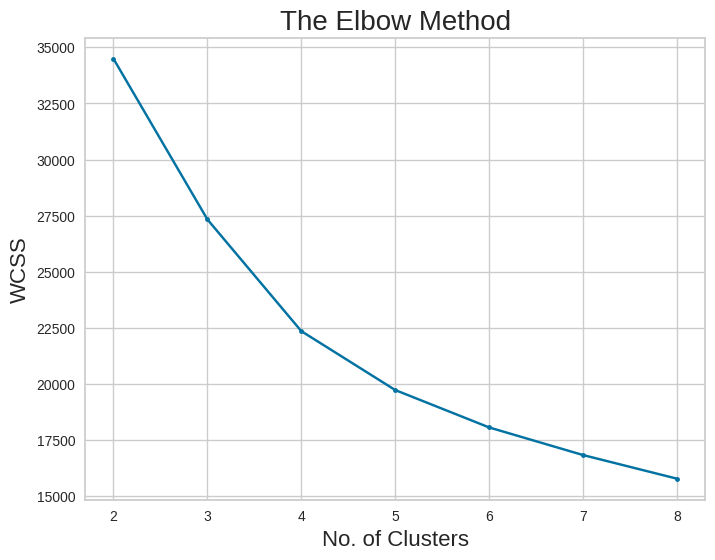

In [43]:
#Variabel kosong untuk wcss
wcss = []

#Membuat iterasi dari 2-15 untuk nilai k terbaik
for i in range(2, 9):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
    km.fit(X_pca)
    wcss.append(km.inertia_)

#Membuat visualisasi wcss
plt.plot(range(2, 9), wcss, marker =".")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters', fontsize = 16)
plt.ylabel('WCSS', fontsize = 16)
plt.show()

Observasi:
- terlihat bahwa garis bersiku akhir berada pada cluster ke 5. Hal ini berarti pada penambahan diatas 5 cluster, tidak berpengarus signifikan terhadap variansi inersia.

#### Metode Silhouette

Selanjutnya dilakukan pengecekan score silhouette pada setiap cluster untuk n_clusters

In [44]:
#Print nilai rata-rata silhouette score
for i in np.arange(2,8):
  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
  km.fit(X_pca)
  score = silhouette_score(X_pca, km.labels_, metric='euclidean')
  print('Silhouette Score Komponen', i ,':' ,'%.3f' % score)

Silhouette Score Komponen 2 : 0.538
Silhouette Score Komponen 3 : 0.273
Silhouette Score Komponen 4 : 0.271
Silhouette Score Komponen 5 : 0.270
Silhouette Score Komponen 6 : 0.228
Silhouette Score Komponen 7 : 0.235


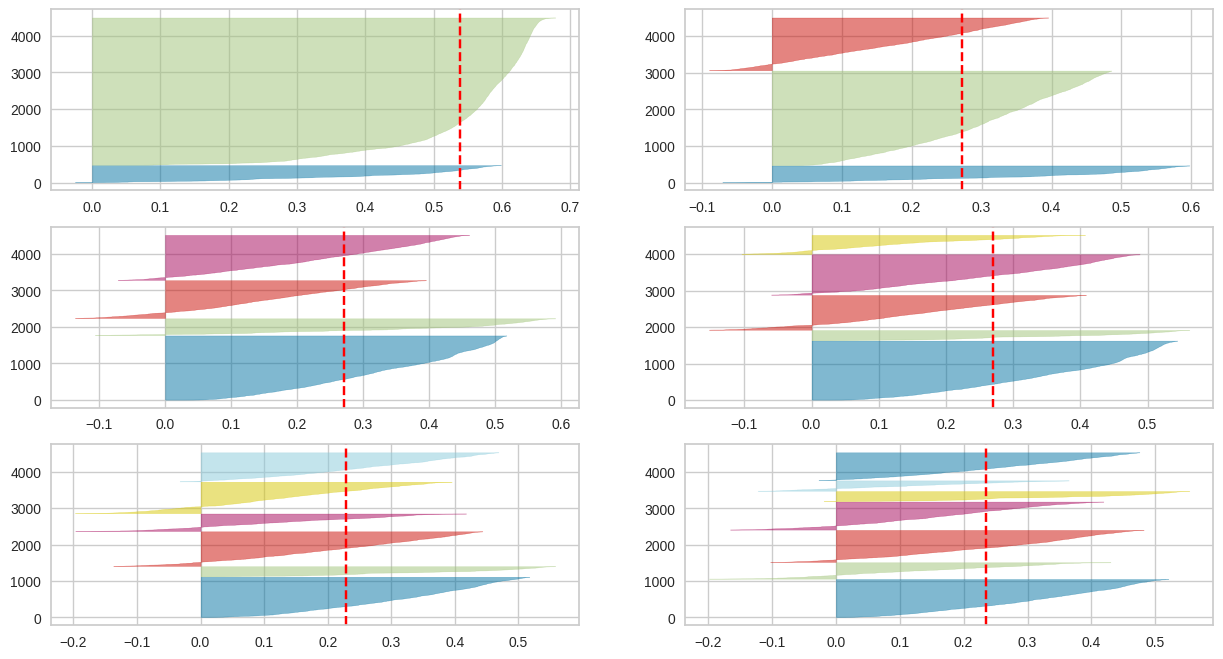

In [45]:
#Visualisasikan skor silholuette
fig, ax = plt.subplots(3, 2, figsize = (15,8))
for i in np.arange(2,8):
  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
  q, mod = divmod(i,2)

  visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax = ax[q-1][mod])
  visualizer.fit(X_pca)

Observasi:
- Berdasarkan skor silhoutte tersebut, rata-rata skore silhouette pada cluster 2 sangat baik
-Sementara berdasarkan gambar, silhouette dengan dimensi terbaik adalah cluster ke 5 karena dimensi lebih merata dibanding yang lain.

**Jumlah n_cluster yang dipilih:**
- `n_clusters` 5 dipilih berdasarkan elbow curve bersiku pada n_component 5
- visualisasi silhoutte pada cluster 5 lebih merata, meskipun pada cluster ke 2 skornya sudah sangat baik

#### Clustering berdasarkan `n_cluster`

Selanjutnya lakukan clustering dengan menggunakan K-Means

In [46]:
#lakukan fit,fraining dan prediksi nilai KMeans
km_final = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
clusters = km_final.fit_predict(X_pca)
clusters

array([0, 0, 0, ..., 3, 2, 2], dtype=int32)

In [47]:
#Print iterasi yang konvergen
km_final.n_iter_

10

#### Visualisasi Cluster (PCA 2 Dimensi)

Sealnjutnya lakukan reduksi dataframe ke 2 dimensi menggunakan PCA dan visualisasikan cluster yang telah diprediksi.

In [48]:
#Reduksi komponen dengan PCA
pca_visualisasi = PCA(n_components=2)
pca_visualisasi.fit(df_fs)
X_visualisasi = pca_visualisasi.transform(df_fs)

In [49]:
#dataframe dengan label PC1 dan PC2
reduced_df= pd.DataFrame(X_visualisasi, columns= ['PC1','PC2'])
reduced_df.head()

,PC1,PC2
0,-1.190313,-0.559503
1,-1.221485,-0.478234
2,-1.209211,-0.511290
3,-1.113875,0.390426
4,-1.058003,1.874338


In [50]:
#Concat dengan Cluster
reduced_df['Clusters']= clusters
reduced_df.head()

,PC1,PC2,Clusters
0,-1.190313,-0.559503,0
1,-1.221485,-0.478234,0
2,-1.209211,-0.511290,0
3,-1.113875,0.390426,0
4,-1.058003,1.874338,2


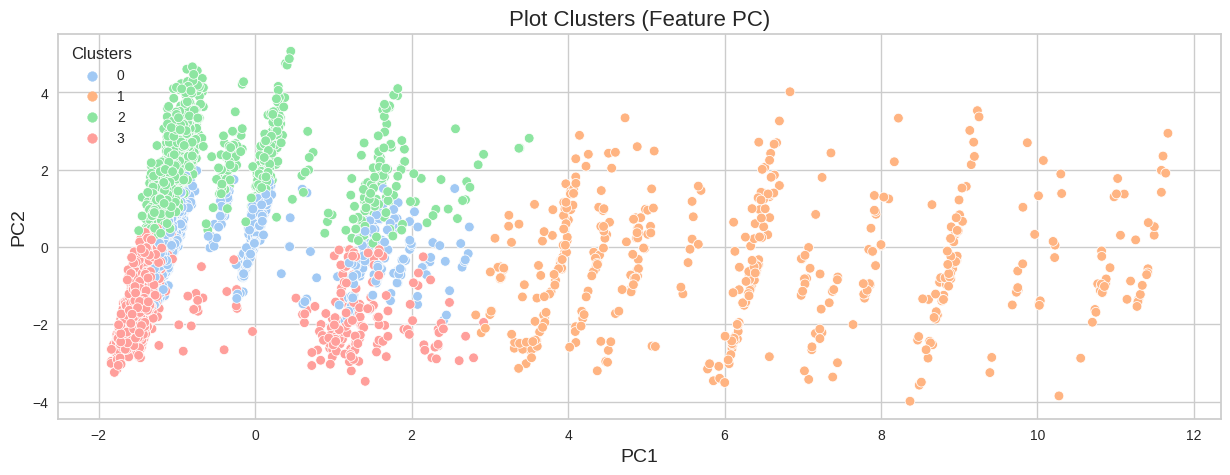

In [51]:
#visualisasikan cluster tersebut
plt.figure(figsize=(15,5))
sns.scatterplot(x='PC1', y='PC2', data=reduced_df, hue="Clusters",palette='pastel')
plt.title('Plot Clusters (Feature PC)',fontsize=16)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.show()

Observasi:

- Berdasarkan gambar visualisasi:
  - setiap cluster yang memiliki PC1>2 dan PC2>2 banyak yang datanya tersebar
  - pada cluster 0 data terpusat pada titik PC1 < 1 dan PC2 < 2
  - pada cluster 1 data terpusat pada titik PC1 > 5 dan PC2 < 4
  - Pada cluster 2 data terpusat pada titik PC1 < 2 dan PC2 > 0
  - pada cluster 3 data terpusat pada PC1 < 2 dan PC1 < 1
  - pada cluster 4 data terpusat pada PC1< 6 dan PC2 < 4

## 9 Model Evaluasi

Selanjutnya untuk melakukan evaluasi karakteristik setiap cluster, perlu dilakukan concat dataframe sebelum PCA dan hasil cluster

### Statistik Deskripsi

In [52]:
#Concat dengan cluster
df_cluster = df_imputer.copy()
df_cluster['Clusters']= clusters
df_cluster

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,16.581535,1.000000,200.00,0.00,200.00,0.000000,0.125000,0.000000,0.125000,0.000000,0.0,2.0,1200.0,0.000000,602.737860,0.000000,12.0,0
1,943.584041,0.875000,103.00,103.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0.0,1.0,1000.0,215.325023,410.484825,0.000000,12.0,0
2,1.979916,1.000000,80.00,80.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0.0,1.0,1500.0,0.000000,566.121277,0.000000,12.0,0
3,461.455720,1.000000,585.00,585.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0.0,1.0,1000.0,258.032630,151.696433,0.000000,12.0,0
4,1053.594730,1.000000,1450.00,1450.00,0.00,0.000000,0.125000,0.125000,0.000000,0.000000,0.0,1.0,1500.0,397.090516,227.143184,0.000000,12.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4470,1079.008102,1.000000,0.00,0.00,0.00,1259.571764,0.000000,0.000000,0.000000,0.269697,9.0,0.0,1200.0,1379.635287,271.364415,0.090909,12.0,3
4471,809.582978,0.909091,0.00,0.00,0.00,1506.959382,0.000000,0.000000,0.000000,0.236364,7.0,0.0,4150.0,2737.101373,241.645387,0.090909,12.0,3
4472,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.283333,9.0,20.0,10100.0,1039.000037,886.050237,0.000000,12.0,3
4473,4840.545574,1.000000,1595.93,275.20,0.00,868.130134,0.454545,0.454545,0.000000,0.116667,0.4,25.0,6000.0,905.844846,1296.623495,0.090909,12.0,2


In [53]:
#cek informasi statistik deskripsi setiap cluster dan tampilkan keseluruhan datanya
pd.set_option('display.max_columns', None)
df_describe=df_cluster.groupby('Clusters').describe()
df_describe

BALANCE                                                   \
           count         mean          std       min          25%   
Clusters                                                            
0         1756.0   628.264009   803.934015  0.000000    33.220036   
1          458.0   526.163409   835.455401  0.009684    45.951223   
2         1032.0  1507.999836  1314.676485  0.000000   352.493390   
3         1229.0  2080.881578  1250.870201  0.000000  1089.696979   

                                                BALANCE_FREQUENCY            \
                  50%          75%          max             count      mean   
Clusters                                                                      
0          209.334312  1057.006168  4539.839383            1756.0  0.975476   
1          189.421861   591.581089  4925.502001             458.0  0.964446   
2         1134.909435  2389.542954  4939.646030            1032.0  0.981554   
3         1912.691045  2951.220065  4932.396527            1229.0  0.980995   

                                                 PURCHASES               \
               std       min  25%  50%  75%  max     count         mean   
Clusters                                                                  
0         0.065306  0.727273  1.0  1.0  1.0  1.0    1756.0   413.695060   
1         0.074659  0.727273  1.0  1.0  1.0  1.0     458.0   749.909528   
2         0.053215  0.727273  1.0  1.0  1.0  1.0    1032.0  1443.013072   
3         0.053451  0.727273  1.0  1.0  1.0  1.0    1229.0   177.489370   

                                                                      \
                 std     min       25%       50%        75%      max   
Clusters                                                               
0         451.015631    0.00    91.880   287.400   568.3100  2616.00   
1         724.868666    0.00   133.215   488.950  1290.6025  2732.66   
2         560.504095  258.74  1005.385  1376.681  1835.1625  2742.33   
3         340.941532    0.00     0.000     0.000   226.9500  2463.00   

         ONEOFF_PURCHASES                                                \
                    count        mean         std  min      25%     50%   
Clusters                                                                  
0                  1756.0   86.110760  156.631194  0.0    0.000    0.00   
1                   458.0  238.474354  374.935706  0.0    0.000    0.00   
2                  1032.0  660.074308  394.433987  0.0  300.096  639.14   
3                  1229.0   74.190846  162.971731  0.0    0.000    0.00   

                            INSTALLMENTS_PURCHASES                          \
               75%      max                  count        mean         std   
Clusters                                                                     
0         109.5200  1000.00                 1756.0  235.540851  278.760447   
1         353.4725  1432.86                  458.0  283.034808  316.738476   
2         990.5275  1450.73                 1032.0  370.954713  352.113233   
3          56.7000  1200.00                 1229.0   72.878143  188.526875   

                                                  CASH_ADVANCE               \
          min     25%      50%       75%      max        count         mean   
Clusters                                                                      
0         0.0   0.000  133.255  386.4725  1200.00       1756.0    71.884504   
1         0.0   0.000  184.435  438.8120  1195.81        458.0   365.386965   
2         0.0  15.185  305.655  621.8480  1209.80       1032.0   255.473709   
3         0.0   0.000    0.000    0.0000  1201.70       1229.0  1141.144809   

                                                                              \
                 std  min         25%          50%          75%          max   
Clusters                                                                       
0         193.782411  0.0    0.000000     0.000000     0.000000  1450.172

In [54]:
#Tampilkan nilai rata-rata keseluruhan
df_loc=df_describe.iloc[:,1::8].T
df_loc

,Clusters,0,1,2,3
BALANCE,mean,628.264009,526.163409,1507.999836,2080.881578
BALANCE_FREQUENCY,mean,0.975476,0.964446,0.981554,0.980995
PURCHASES,mean,413.695060,749.909528,1443.013072,177.489370
ONEOFF_PURCHASES,mean,86.110760,238.474354,660.074308,74.190846
INSTALLMENTS_PURCHASES,mean,235.540851,283.034808,370.954713,72.878143
CASH_ADVANCE,mean,71.884504,365.386965,255.473709,1141.144809
PURCHASES_FREQUENCY,mean,0.496353,0.608621,0.799902,0.176935
ONEOFF_PURCHASES_FREQUENCY,mean,0.069754,0.176587,0.458996,0.058618
PURCHASES_INSTALLMENTS_FREQUENCY,mean,0.415028,0.474832,0.525508,0.117770
CASH_ADVANCE_FREQUENCY,mean,0.025992,0.076694,0.057232,0.237422


Berdasarkan informasi describe tersebut, karakteristik dan highlight dari masing-masing cluster adalah sebagai berikut:

**Cluster 0**
  - sering melakukan update balance
  - memiliki Payment terendah
  - jarang melakukan pembelian
  - jarang melakukan penarikan tunai kartu kredit (Cash Advance Frequency terendah)
  - memiliki credit limit terendah

**Cluster 1**
  - memiliki rata-rata balance paling terendah
  - sering melakukan update balance
  - paling jarang melakukan metode cash advance
  - memiliki minimum payment terendah
  - tingkat persentase full payment yang paling tertinggi

**Cluster 2**
  - sering update balance
  - memiliki Payment tertinggi
  - memiliki jumlah rata-rata Oneoff Purchase dan Installment Payment tertinggi
  - paling sering melakukan belanja
  - sering melakukan pembelian dengan metode one off purchases
  - Oneoff Payment Frequency tertinggi
  - paling sering belanja dengan barang-barang mahal (Payment Transaction tertinggi)
  - memiliki Credit Limit tertinggi

**Cluster 3**
- Memiliki balance tertinggi
- Balance frequency tertinggi
- sering melakukan update balance
- OneOff Payment terendah
- Installment Payment terendah
- Cash advance tertinggi
- payment frequency terendah
- Oneoff Payment Frequency terendah
- Payment Installment Frequency terendah
- Cash Advance Transaction tertinggi
- Payment transaction terendah
- Minimum Payment tertinggi
- Persentase Frequency Payment terendah

Selanjutnya divisualisasikan pada setiap cluster untuk mengetahui apakah informasi diatas sudah sesuai atau belum

### Visualisasi

#### Balance Amount vs Purchase Amount

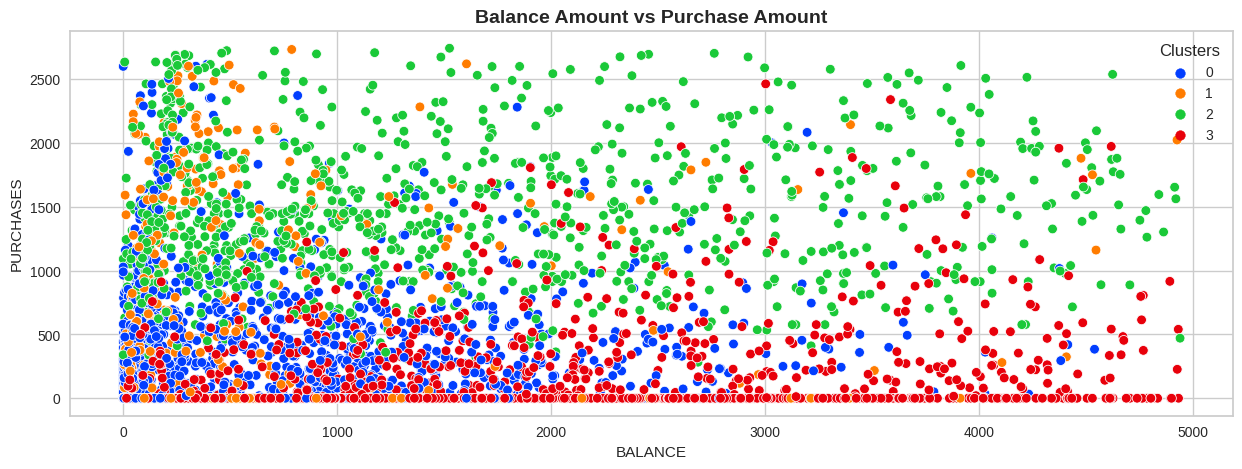

In [55]:
#Visualisasi Balance Amount vs Purchase Amount
plt.figure(figsize=(15,5))

sns.scatterplot(x="BALANCE", y="PURCHASES", hue="Clusters", data=df_cluster, palette="bright")
plt.title('Balance Amount vs Purchase Amount', fontsize=14, fontweight='bold')
plt.legend(title='Clusters', loc='upper right')
plt.show()

In [56]:
#print describe
df_cluster[['BALANCE','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE','Clusters']].groupby('Clusters').describe()


BALANCE                                                   \
           count         mean          std       min          25%   
Clusters                                                            
0         1756.0   628.264009   803.934015  0.000000    33.220036   
1          458.0   526.163409   835.455401  0.009684    45.951223   
2         1032.0  1507.999836  1314.676485  0.000000   352.493390   
3         1229.0  2080.881578  1250.870201  0.000000  1089.696979   

                                                ONEOFF_PURCHASES              \
                  50%          75%          max            count        mean   
Clusters                                                                       
0          209.334312  1057.006168  4539.839383           1756.0   86.110760   
1          189.421861   591.581089  4925.502001            458.0  238.474354   
2         1134.909435  2389.542954  4939.646030           1032.0  660.074308   
3         1912.691045  2951.220065  4932.396527           1229.0   74.190846   

                                                               \
                 std  min      25%     50%       75%      max   
Clusters                                                        
0         156.631194  0.0    0.000    0.00  109.5200  1000.00   
1         374.935706  0.0    0.000    0.00  353.4725  1432.86   
2         394.433987  0.0  300.096  639.14  990.5275  1450.73   
3         162.971731  0.0    0.000    0.00   56.7000  1200.00   

         INSTALLMENTS_PURCHASES                                                \
                          count        mean         std  min     25%      50%   
Clusters                                                                        
0                        1756.0  235.540851  278.760447  0.0   0.000  133.255   
1                         458.0  283.034808  316.738476  0.0   0.000  184.435   
2                        1032.0  370.954713  352.113233  0.0  15.185  305.655   
3                        1229.0   72.878143  188.526875  0.0   0.000    0.000   

                            CASH_ADVANCE                                \
               75%      max        count         mean         std  min   
Clusters                                                                 
0         386.4725  1200.00       1756.0    71.884504  193.782411  0.0   
1         438.8120  1195.81        458.0   365.386965  636.194827  0.0   
2         621.8480  1209.80       1032.0   255.473709  526.504210  0.0   
3           0.0000  1201.70       1229.0  1141.144809  672.235877  0.0   

                                                             
                 25%          50%          75%          max  
Clusters                                                     
0           0.000000     0.000000     0.000000  1450.172456  
1           0.000000     0.000000   510.340104  2723.362442  
2           0.000000     0.000000   196.850386  2728.576925  
3         579.238101  1068.127248  1580.872497  2744.808962

***Observasi:***

**Cluster 0**
- memiliki value pembelian dengan metode cash_advance paling rendah yang terpusat dibawah 1500

**Cluster 1**
- memiliki tingkat balance terendah

**Cluester 2**
- memiliki tingkat pembelian tertinggi dengan menggunakan metode oneoff_purchases dan installment purchases yang terpusat dibawah 1500

**Cluster 3**
- memiliki balance teringgi dengan cash advance paling tinggi yang terpusat dibawah 3000

#### Credit Limit vs Purchase Amount

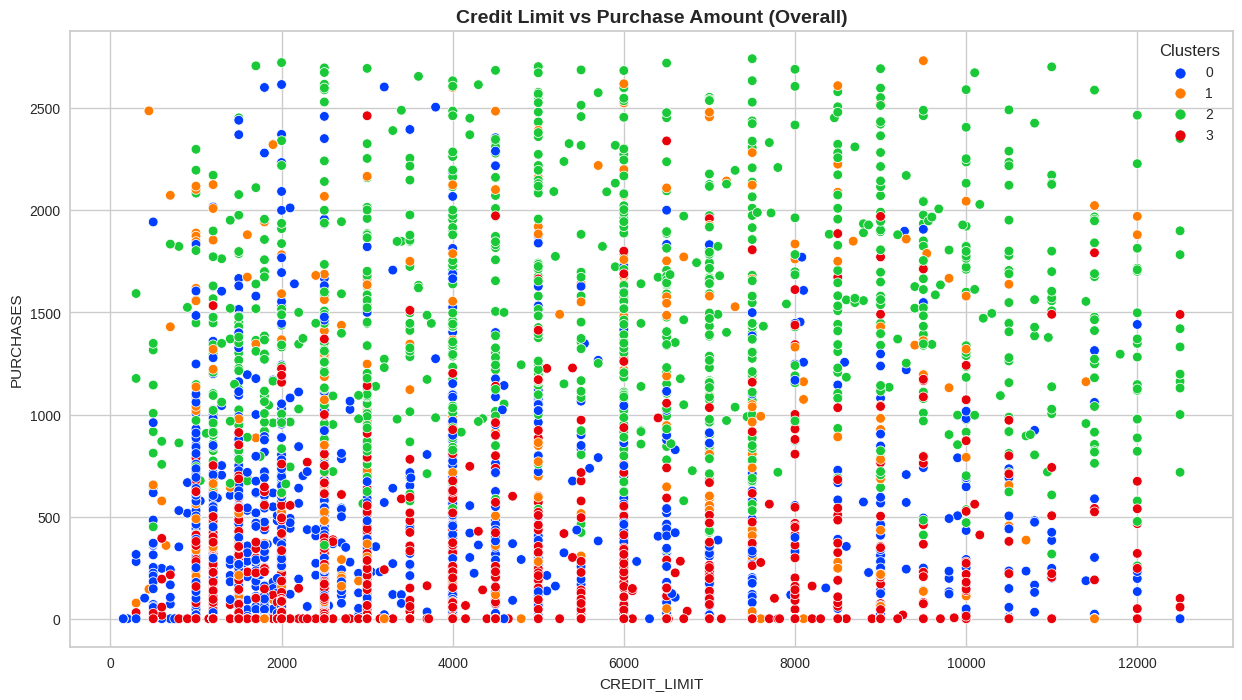

In [57]:
#Visualisasi Credit Limit VS Purchase Amount
plt.figure(figsize=(15,8))

sns.scatterplot(x="CREDIT_LIMIT", y="PURCHASES", hue="Clusters", data=df_cluster, palette= "bright")
plt.title('Credit Limit vs Purchase Amount (Overall)', fontsize=14, fontweight='bold')
plt.legend(title='Clusters', loc='upper right')
plt.show()

In [58]:
#Print informasi data
df_cluster[['CREDIT_LIMIT','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES','CASH_ADVANCE','Clusters']].groupby('Clusters').describe()

CREDIT_LIMIT                                                   \
                count         mean          std    min     25%     50%   
Clusters                                                                 
0              1756.0  3132.001392  2467.691316  150.0  1287.5  2400.0   
1               458.0  4058.449782  2835.104187  300.0  1500.0  3000.0   
2              1032.0  5938.674242  3155.118688  300.0  3000.0  6000.0   
3              1229.0  4435.508544  2985.551227  300.0  2000.0  3500.0   

                          ONEOFF_PURCHASES                               \
             75%      max            count        mean         std  min   
Clusters                                                                  
0         4000.0  12500.0           1756.0   86.110760  156.631194  0.0   
1         6000.0  12000.0            458.0  238.474354  374.935706  0.0   
2         8500.0  12500.0           1032.0  660.074308  394.433987  0.0   
3         6500.0  12500.0           1229.0   74.190846  162.971731  0.0   

                                             INSTALLMENTS_PURCHASES  \
              25%     50%       75%      max                  count   
Clusters                                                              
0           0.000    0.00  109.5200  1000.00                 1756.0   
1           0.000    0.00  353.4725  1432.86                  458.0   
2         300.096  639.14  990.5275  1450.73                 1032.0   
3           0.000    0.00   56.7000  1200.00                 1229.0   

                                                                           \
                mean         std  min     25%      50%       75%      max   
Clusters                                                                    
0         235.540851  278.760447  0.0   0.000  133.255  386.4725  1200.00   
1         283.034808  316.738476  0.0   0.000  184.435  438.8120  1195.81   
2         370.954713  352.113233  0.0  15.185  305.655  621.8480  1209.80   
3          72.878143  188.526875  0.0   0.000    0.000    0.0000  1201.70   

         CASH_ADVANCE                                                         \
                count         mean         std  min         25%          50%   
Clusters                                                                       
0              1756.0    71.884504  193.782411  0.0    0.000000     0.000000   
1               458.0   365.386965  636.194827  0.0    0.000000     0.000000   
2              1032.0   255.473709  526.504210  0.0    0.000000     0.000000   
3              1229.0  1141.144809  672.235877  0.0  579.238101  1068.127248   

                                    
                  75%          max  
Clusters                            
0            0.000000  1450.172456  
1          510.340104  2723.362442  
2          196.850386  2728.576925  
3         1580.872497  2744.808962

***Observasi:***

**Cluster 0**
- memiliki credit limit terendah terpusat dibawah 1300
- memiliki value pembelian dengan metode cash advance paling rendah

**Cluster 1**
- memiliki value pembelian dengan metode cash advance tertinggi yang terpusat dibawah 2800

**Cluester 2**
- memiliki credit limit tertinggi yang terpusat dibawah 9000
- memiliki value pembelian dengan metode oneoff_purchases dan installment purchases tertinggi.

**Cluster 3**
- memiliki valuepembelian dengan metode oneoff_purchases dan installment purchases terendah
- memiliki value pembelian dengan metode cash advance paling tinggi yang berpusat dibawah 3000

### Kesimpulan Karakteristik Setiap Cluster

Berdasarkan informasi-informasi yang telah dianalisis, dapat disimpulkan bahwa:

**Client 0 (Tipe client hemat)**

Client ini jarang melakukan pembelian dan memilih memiliki limit balance yang rendah yang berarti value payment yang dilakukan client ini juga akan rendah, sebanding dengan limit balancenya. Meskipun demikian, client ini sering melakukan update balance.


**Client 1 (Tipe client yang terbebani dengan hutang)**

Client ini memiliki balance terendah, jarang melakukan metode cash advance namun paling tinggi dalam dalam membayar kembali seluruh tagihan yang diberikan.

**Client 2 (tipe client konsumtif dan mengikuti tren)**
client ini memiliki tingkat balance tertinggi dan paling sering berbelanja. Namun, karena tren produk yang selalu berubah-ubah, sehingga client ini memilih untuk menggunakan metode cicilan agar seluruh tren barang pada bulan tersebut dapat dimiliki dan balance di kartu kredit tidak langsung habis.


**Client 3 (Tipe client yang suka barang berkualitas yang dibayar dengan lunas)**

Client ini memiliki balance yang tinggi dan memiliki tingkat cash_advance yang tinggi. Minimum purchase dari client ini juga tertinggi diantara yang lainnya, namun memiliki metode cicilan terendah. Hal ini berarti, client ini hanya suka barang-barang mahal berkualitas tinggi yang dibwar secara lunas.

Bisnis (Strategi Marketing):

Berdasarkan pengelompokkan diatas, berikut adalah bisnis (strategi marketing) yang sebaiknya dilakukan:

1. **Cluster 0 (Tipe client hemat)**
Karena client hemat hanya ingin mengeluarkan uang sesuai kebutuhan mereka, ada baiknya jika diberikan reward cash back/potongan x% jika client sering melakukan pembelian/transaksi belanja. Reward ini dimaksudkan agar client dapat lebih sering melakukan belanja.

2. **Client 1 (Tipe client lebih suka membayar cash)**
CLient ini cenderung membayar full secara cash setiap pembelian dan sayangnya tingkat pembelian yang dilakukan relatif jarang. Strategi yang dilakukan dapat dengan memberi diskon x% jika melakukan pembelian/pembayaran secara cashless.

3. **Client 2 (tipe client konsumtif dan mengikuti tren)**
Client ini cenderung mengikuti tren produk yang paling terkenal dan terbaru. Oleh karena itu, sebaiknya pihak jasa kredit card dapat bekerja sama dengan suplier produk tren, dan memberikan diskon atau cashback jika membeli produk di perusahaan tersebut.


4. **Client 3 (Tipe client yang suka barang berkualitas yang dibayar dengan lunas)**
Client pada cluster ini sangat jarang melakukan pembelian, namun sekalinya melakukan pembelian harga produk tersebut memiliki value/harga yang sangat tinggi. Strateginya adalah pelajari perilaku pembelian client-client ini dan bekerja sama dengan perusahaan yang menjual barang-barang yang diincar oleh client. Berikan opsi diskon jika pembelian dilakukan secara cicilan.



## 10 Model Saving

### Save Data

In [59]:
# Save the Files

with open('imputer.pkl', 'wb') as file_1:
  pickle.dump(imputer, file_1)

with open('scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('pca_final.pkl', 'wb') as file_3:
  pickle.dump(pca_final, file_3)

with open('km_final.pkl', 'wb') as file_4:
  pickle.dump(km_final, file_4)

## 11 Model Inference

In [60]:
df.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,16.581535,0.125,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8
1,943.584041,0.875,103.0,103.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,215.325023,410.484825,0.0,8


### Load Model



In [61]:
#load model
with open('imputer.pkl', 'rb') as file_1:
  imputer = pickle.load(file_1)

with open('scaler.pkl', 'rb') as file_2:
  scaler = pickle.load(file_2)

with open('pca_final.pkl', 'rb') as file_3:
  pca_final = pickle.load(file_3)

with open('km_final.pkl', 'rb') as file_4:
  km_final = pickle.load(file_4)

### Data Baru

In [62]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [63]:
#Buat data baru

data_inf = {
 'BALANCE' : 13047,
 'BALANCE_FREQUENCY' : 1,
 'PURCHASES' : 11202,
 'ONEOFF_PURCHASES' : 1975,
 'INSTALLMENTS_PURCHASES' :255,
 'CASH_ADVANCE' :2138,
 'PURCHASES_FREQUENCY' : 1,
 'ONEOFF_PURCHASES_FREQUENCY' : 0.25,
 'PURCHASES_INSTALLMENTS_FREQUENCY' :0.75,
 'CASH_ADVANCE_FREQUENCY' :0.25,
 'CASH_ADVANCE_TRX' :4,
 'PURCHASES_TRX' :17,
 'CREDIT_LIMIT' :4300,
 'PAYMENTS' :9911,
 'MINIMUM_PAYMENTS' : 785,
 'PRC_FULL_PAYMENT' :0.12,
 'TENURE' : 12
}

data_inf = pd.DataFrame([data_inf])
data_inf

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,13047,1,11202,1975,255,2138,1,0.25,0.75,0.25,4,17,4300,9911,785,0.12,12


### Scaling

In [64]:
#Lakukan scaling
df_scale= pd.DataFrame(scaler.fit_transform(data_inf), columns=data_inf.columns.to_list())
df_scale

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PCA

In [65]:
#Reduksi komponen menggunakan PCA
X_pca = pca_final.transform(df_scale)
X_pca

array([[-1.13332148, -0.1311797 , -1.37885701, -0.15332876,  0.29589024,
         0.20940298]])

### Prediksi Cluster

In [66]:
# Predict using Random Forest Opt
y_pred_inf = km_final.predict(X_pca)
y_pred_inf

array([0], dtype=int32)

Observasi:
- Untuk data baru (data_inf), sesuai dengan data yang diberikan maka kriteria tersebut masuk ke dalam cluster ke 0 (cluster 0: tipe client hemat)

## 12 Pengambilan Kesimpulan

Poin utama untuk mengembangkan sebuah bisnis adalah marketing yang tepat sasaran. Dalam pemodelan clustering customer data kartu kredit ini didapatkan bahwa terdapat 4 cluster dengan karakteristik-karakteristiknya masing-masing, diantaranya: cluster 0(tipe client hemat), cluster 1 (Tipe client lebih suka membayar cash), cluster 2 (tipe client konsumtif dan mengikuti tren), dan cluster 3 (Tipe client yang suka barang berkualitas yang dibayar dengan lunas).
